In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet50"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    edge_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)
        
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr.detach()), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae 
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    edge_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [46]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f67c03f56a0>,)

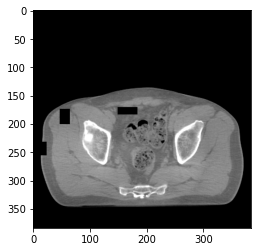

In [28]:
plt.imshow(x.squeeze(), 'gray'),

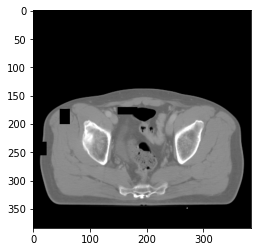

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)

In [34]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [36]:
model

Generator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slo

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [ ]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:48,  1.00s/it]
168it [00:47,  3.53it/s]
24it [00:06,  3.76it/s]
168it [02:42,  1.03it/s]
168it [00:42,  3.98it/s]
24it [00:05,  4.01it/s]
168it [02:42,  1.03it/s]
168it [00:42,  3.99it/s]
24it [00:06,  3.78it/s]
168it [02:41,  1.04it/s]
168it [00:50,  3.33it/s]
24it [00:06,  3.79it/s]
168it [02:47,  1.00it/s]
168it [00:42,  3.96it/s]
24it [00:05,  4.53it/s]
168it [02:49,  1.01s/it]
168it [00:46,  3.60it/s]
24it [00:05,  4.52it/s]
168it [02:46,  1.01it/s]
168it [00:47,  3.55it/s]
24it [00:06,  3.50it/s]
168it [02:46,  1.01it/s]
168it [00:45,  3.69it/s]
24it [00:08,  2.77it/s]
168it [02:41,  1.04it/s]
168it [00:41,  4.02it/s]
24it [00:06,  3.87it/s]
168it [02:41,  1.04it/s]
168it [00:43,  3.89it/s]
24it [00:06,  3.89it/s]
168it [02:41,  1.04it/s]
168it [00:50,  3.33it/s]
24it [00:06,  3.80it/s]
168it [02:48,  1.00s/it]
168it [00:43,  3.83it/s]
24it [00:11,  2.17it/s]
168it [02:47,  1.00it/s]
168it [00:43,  3.89it/s]
24it [00:05,  4.45it/s]
168it [02:46,  1.01it/s]
168it [00:47,

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [43]:
model = model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [44]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8396877646446228
psnr score = 21.3548583984375
snr score = 11.417795181274414
mae error = 0.029840435832738876
air dice score = 0.9899573558658046
bone dice score = 2.9036004644917653e-11
contour dice score = 0.05075528845191002


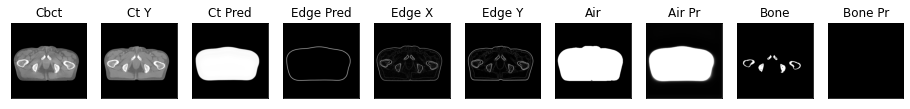

1it [00:00,  1.51it/s]

ssim score = 0.8410093784332275
psnr score = 21.32370948791504
snr score = 11.434182167053223
mae error = 0.02988823875784874
air dice score = 0.9905564491459452
bone dice score = 2.8868360276302878e-11
contour dice score = 0.09327679872512817


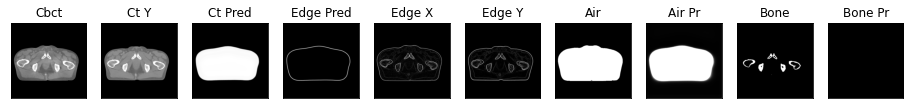

2it [00:01,  1.74it/s]

ssim score = 0.8368330597877502
psnr score = 20.938617706298828
snr score = 11.211986541748047
mae error = 0.031478751450777054
air dice score = 0.9913254342211706
bone dice score = 2.3963575364870272e-11
contour dice score = 0.12727272510528564


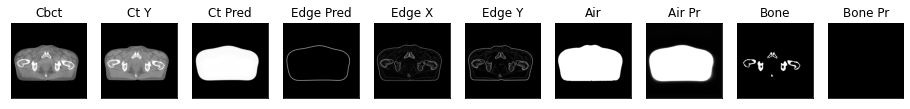

3it [00:01,  1.96it/s]

ssim score = 0.8343852758407593
psnr score = 20.743486404418945
snr score = 11.106108665466309
mae error = 0.03271856904029846
air dice score = 0.9914260061369753
bone dice score = 2.1473051320131565e-11
contour dice score = 0.1530054658651352


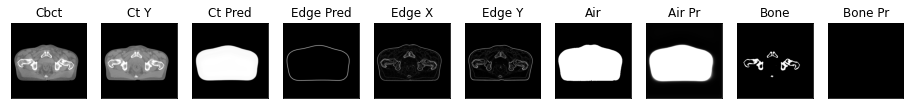

4it [00:01,  2.14it/s]

ssim score = 0.8321502804756165
psnr score = 20.728473663330078
snr score = 11.131397247314453
mae error = 0.033577628433704376
air dice score = 0.9913978281743485
bone dice score = 1.9286403085452526e-11
contour dice score = 0.19951337575912476


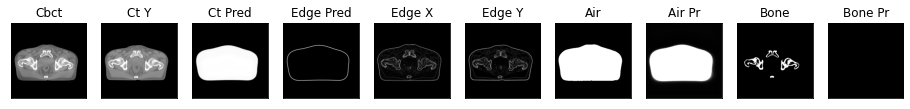

5it [00:02,  2.29it/s]

ssim score = 0.8314557075500488
psnr score = 20.43421745300293
snr score = 10.973677635192871
mae error = 0.03532705828547478
air dice score = 0.9918049885269921
bone dice score = 1.6329196603260463e-11
contour dice score = 0.23062843084335327


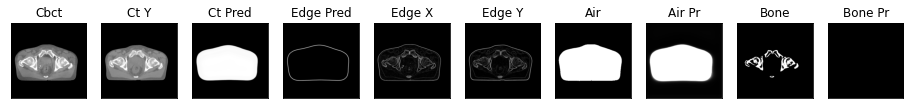

6it [00:02,  2.42it/s]

ssim score = 0.8341426849365234
psnr score = 20.377647399902344
snr score = 10.893049240112305
mae error = 0.035282496362924576
air dice score = 0.9894499621076249
bone dice score = 1.563966218305224e-11
contour dice score = 0.3451652526855469


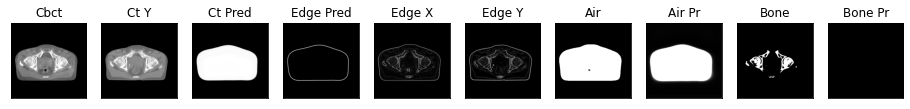

7it [00:02,  2.52it/s]

ssim score = 0.8427790403366089
psnr score = 20.789087295532227
snr score = 11.118950843811035
mae error = 0.03258330374956131
air dice score = 0.990187117704378
bone dice score = 1.7394329448297195e-11
contour dice score = 0.25846153497695923


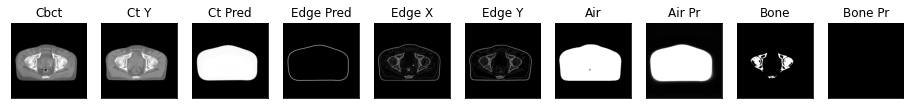

8it [00:03,  2.60it/s]

ssim score = 0.8469635248184204
psnr score = 20.94936752319336
snr score = 11.18467903137207
mae error = 0.0315023735165596
air dice score = 0.989640709485078
bone dice score = 1.898974553704919e-11
contour dice score = 0.33848053216934204


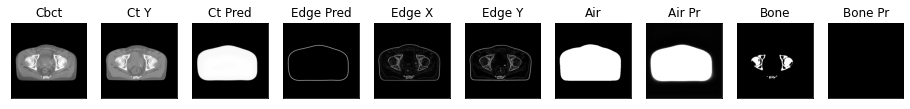

9it [00:03,  2.65it/s]

ssim score = 0.8526321053504944
psnr score = 21.031124114990234
snr score = 11.251152038574219
mae error = 0.030785318464040756
air dice score = 0.9891861126920998
bone dice score = 1.9920318724702783e-11
contour dice score = 0.32961586117744446


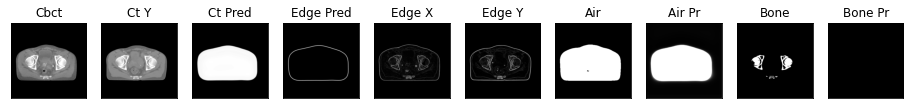

10it [00:03,  2.69it/s]

ssim score = 0.8588259816169739
psnr score = 20.94656753540039
snr score = 11.198863983154297
mae error = 0.030598269775509834
air dice score = 0.9896373587028903
bone dice score = 2.105706464474506e-11
contour dice score = 0.30540037155151367


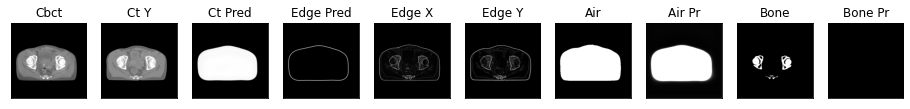

11it [00:04,  2.32it/s]

ssim score = 0.8624063730239868
psnr score = 20.764305114746094
snr score = 11.040314674377441
mae error = 0.030929168686270714
air dice score = 0.9862103715281847
bone dice score = 2.107481559491939e-11
contour dice score = 0.19354838132858276


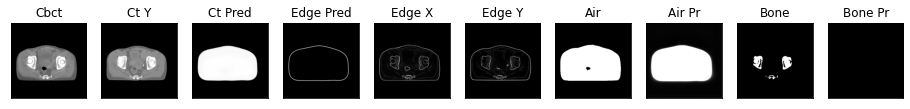

12it [00:04,  2.45it/s]

ssim score = 0.8673149347305298
psnr score = 20.833999633789062
snr score = 11.078086853027344
mae error = 0.030014362186193466
air dice score = 0.9835116973618887
bone dice score = 2.2583559168415004e-11
contour dice score = 0.19863438606262207


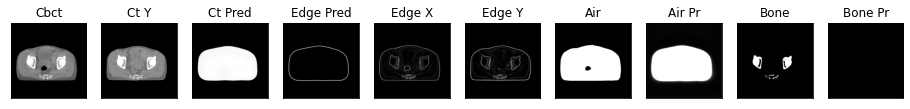

13it [00:05,  2.55it/s]

ssim score = 0.8634870052337646
psnr score = 21.508647918701172
snr score = 11.610774993896484
mae error = 0.02814810909330845
air dice score = 0.9824938895736464
bone dice score = 2.4467824809775684e-11
contour dice score = 0.16750000417232513


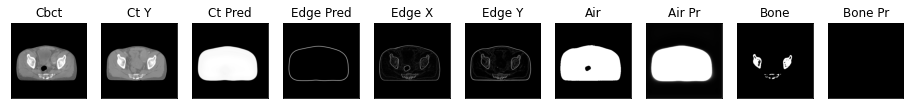

14it [00:05,  2.61it/s]

ssim score = 0.8641009330749512
psnr score = 21.88632583618164
snr score = 11.902791976928711
mae error = 0.027032114565372467
air dice score = 0.9823592994091968
bone dice score = 2.5920165888389833e-11
contour dice score = 0.271990031003952


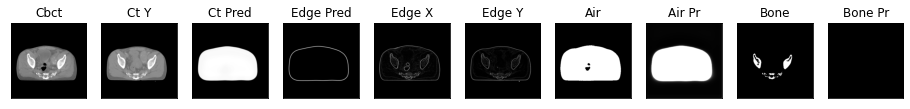

15it [00:05,  2.66it/s]

ssim score = 0.8592932820320129
psnr score = 21.58148765563965
snr score = 11.621438980102539
mae error = 0.028389986604452133
air dice score = 0.9828010346830145
bone dice score = 2.4770869456904362e-11
contour dice score = 0.2703727185726166


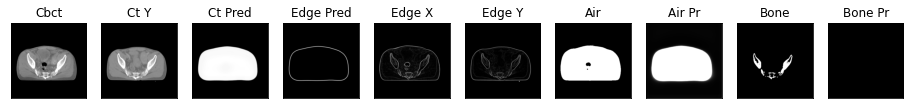

16it [00:06,  2.70it/s]

ssim score = 0.854074239730835
psnr score = 21.154102325439453
snr score = 11.191510200500488
mae error = 0.029593655839562416
air dice score = 0.9794227316669187
bone dice score = 2.3441162681119523e-11
contour dice score = 0.24445851147174835


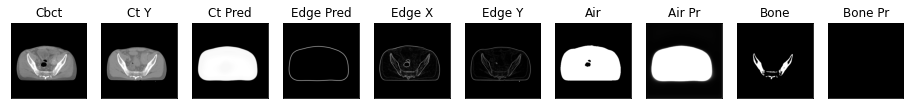

17it [00:06,  2.73it/s]

ssim score = 0.8490325212478638
psnr score = 21.134586334228516
snr score = 11.070233345031738
mae error = 0.030110934749245644
air dice score = 0.9773133625258532
bone dice score = 2.364625206848791e-11
contour dice score = 0.1960049867630005


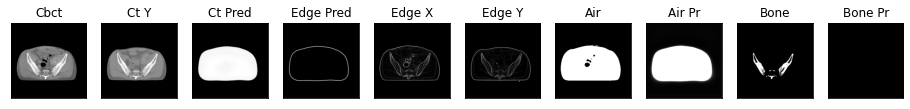

18it [00:06,  2.76it/s]

ssim score = 0.8451754450798035
psnr score = 20.97674560546875
snr score = 10.861711502075195
mae error = 0.03078559786081314
air dice score = 0.9780935337114016
bone dice score = 2.3331777880930195e-11
contour dice score = 0.22934016585350037


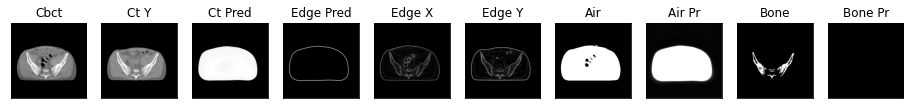

19it [00:07,  2.77it/s]

ssim score = 0.8400955200195312
psnr score = 20.723783493041992
snr score = 10.596439361572266
mae error = 0.0313364714384079
air dice score = 0.981846314780127
bone dice score = 2.4113817216684018e-11
contour dice score = 0.19515305757522583


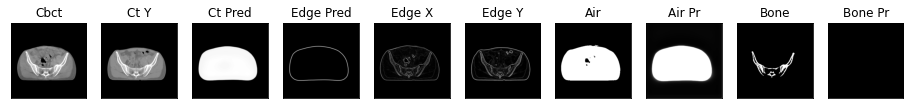

20it [00:07,  2.78it/s]

ssim score = 0.8378992676734924
psnr score = 20.625717163085938
snr score = 10.433526039123535
mae error = 0.031480152159929276
air dice score = 0.9821365716297275
bone dice score = 2.61780104705189e-11
contour dice score = 0.22021892666816711


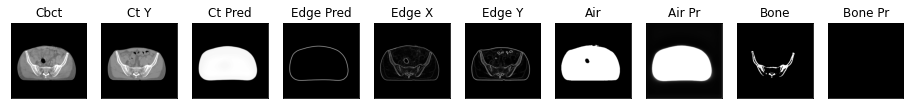

21it [00:08,  2.37it/s]

ssim score = 0.8339903354644775
psnr score = 20.471620559692383
snr score = 10.219999313354492
mae error = 0.03174798935651779
air dice score = 0.9858344301425638
bone dice score = 2.585315408412996e-11
contour dice score = 0.1818181872367859


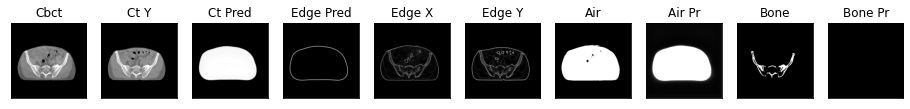

22it [00:08,  2.49it/s]

ssim score = 0.8322731256484985
psnr score = 20.250587463378906
snr score = 9.965538024902344
mae error = 0.0325343981385231
air dice score = 0.9868298013767456
bone dice score = 2.427184465960505e-11
contour dice score = 0.21685172617435455


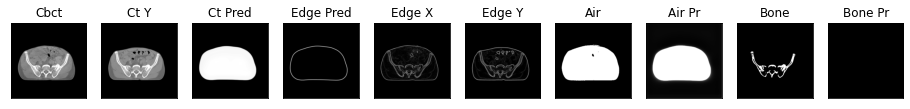

23it [00:08,  2.57it/s]

ssim score = 0.8329107761383057
psnr score = 20.153820037841797
snr score = 9.820206642150879
mae error = 0.033224184066057205
air dice score = 0.9865613727654595
bone dice score = 2.3337222869933788e-11
contour dice score = 0.20891550183296204


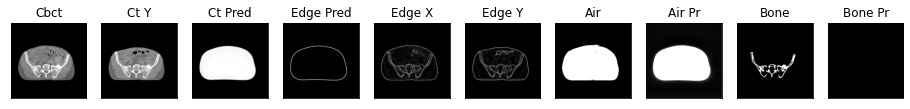

24it [00:09,  2.64it/s]

ssim score = 0.8320325016975403
psnr score = 20.088518142700195
snr score = 9.657905578613281
mae error = 0.033513206988573074
air dice score = 0.983454528718723
bone dice score = 2.2416498542425095e-11
contour dice score = 0.2530282735824585


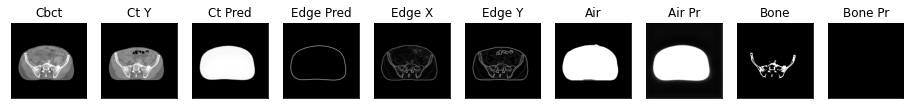

25it [00:09,  2.66it/s]

ssim score = 0.8302074074745178
psnr score = 20.047039031982422
snr score = 9.533693313598633
mae error = 0.033796779811382294
air dice score = 0.9805927768521571
bone dice score = 2.220248667801504e-11
contour dice score = 0.21117165684700012


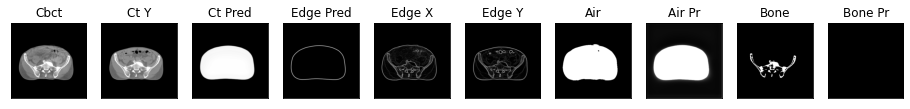

26it [00:10,  2.71it/s]

ssim score = 0.8317214846611023
psnr score = 20.03622817993164
snr score = 9.431694984436035
mae error = 0.03414805606007576
air dice score = 0.9714204261991645
bone dice score = 2.181025081740872e-11
contour dice score = 0.1660851389169693


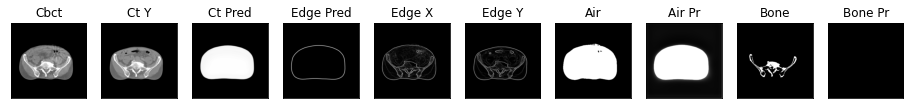

27it [00:10,  2.74it/s]

ssim score = 0.8350900411605835
psnr score = 20.121862411499023
snr score = 9.476222038269043
mae error = 0.03373628482222557
air dice score = 0.9668781847899639
bone dice score = 2.0768431982953927e-11
contour dice score = 0.15525758266448975


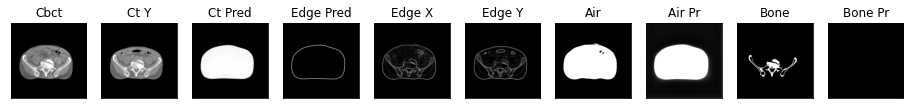

28it [00:10,  2.77it/s]

ssim score = 0.8078585863113403
psnr score = 19.744356155395508
snr score = 11.116514205932617
mae error = 0.049214888364076614
air dice score = 0.9873508059554649
bone dice score = 6.36132315481162e-11
contour dice score = 0.1446317583322525


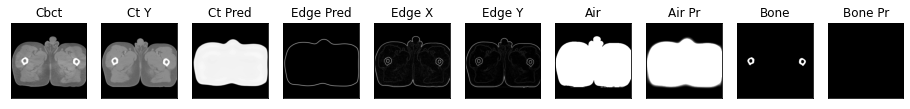

29it [00:11,  2.76it/s]

ssim score = 0.8083525896072388
psnr score = 19.861167907714844
snr score = 11.2725830078125
mae error = 0.04929834604263306
air dice score = 0.9877390997309251
bone dice score = 5.934718100537998e-11
contour dice score = 0.14198605716228485


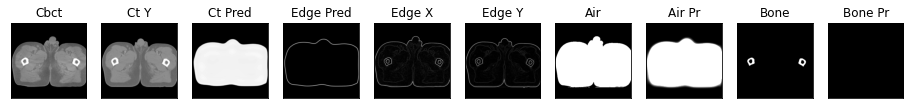

30it [00:11,  2.77it/s]

ssim score = 0.8049249053001404
psnr score = 19.8988037109375
snr score = 11.397666931152344
mae error = 0.04994991794228554
air dice score = 0.9875637966961691
bone dice score = 4.67508181371318e-11
contour dice score = 0.15391579270362854


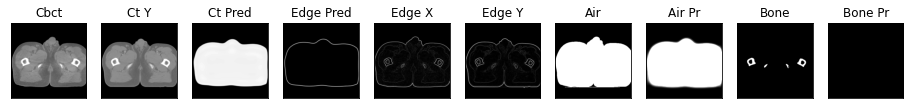

31it [00:12,  2.37it/s]

ssim score = 0.7986732125282288
psnr score = 19.877872467041016
snr score = 11.53929328918457
mae error = 0.051005423069000244
air dice score = 0.9883792782793962
bone dice score = 3.1867431484006776e-11
contour dice score = 0.16085541248321533


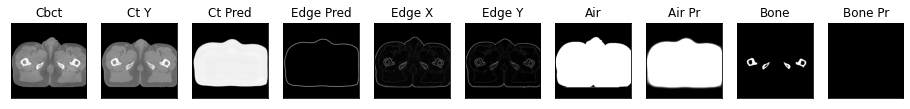

32it [00:12,  2.49it/s]

ssim score = 0.7895072102546692
psnr score = 19.81439971923828
snr score = 11.603963851928711
mae error = 0.05143219232559204
air dice score = 0.9890876095417817
bone dice score = 2.7555800495245087e-11
contour dice score = 0.15622076392173767


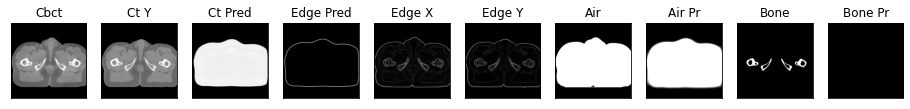

33it [00:12,  2.58it/s]

ssim score = 0.7896789908409119
psnr score = 19.831541061401367
snr score = 11.724343299865723
mae error = 0.051488328725099564
air dice score = 0.9893021431373312
bone dice score = 2.3986567521612218e-11
contour dice score = 0.1461358368396759


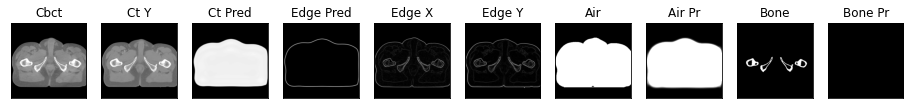

34it [00:13,  2.64it/s]

ssim score = 0.7906403541564941
psnr score = 19.72261619567871
snr score = 11.682519912719727
mae error = 0.05258693918585777
air dice score = 0.9896450405194128
bone dice score = 2.1953896816202988e-11
contour dice score = 0.14880673587322235


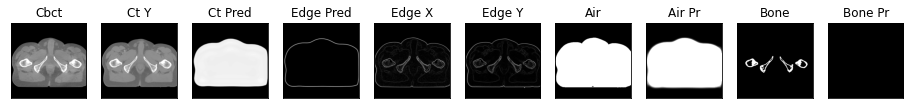

35it [00:13,  2.71it/s]

ssim score = 0.7866411209106445
psnr score = 19.668428421020508
snr score = 11.618441581726074
mae error = 0.05291968211531639
air dice score = 0.9896681887726531
bone dice score = 2.0733982997704042e-11
contour dice score = 0.1419234424829483


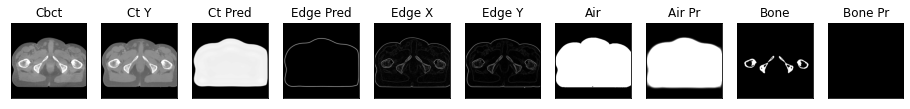

36it [00:13,  2.76it/s]

ssim score = 0.7890244722366333
psnr score = 19.682796478271484
snr score = 11.619144439697266
mae error = 0.05242278054356575
air dice score = 0.9892559351818063
bone dice score = 2.052966536603306e-11
contour dice score = 0.1383824199438095


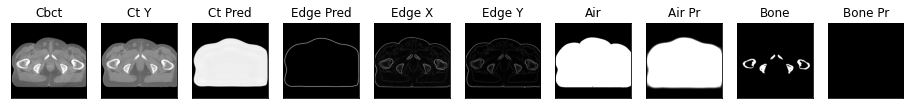

37it [00:14,  2.79it/s]

ssim score = 0.7939161062240601
psnr score = 19.74123764038086
snr score = 11.689586639404297
mae error = 0.052238162606954575
air dice score = 0.9886375015462254
bone dice score = 2.170609941346416e-11
contour dice score = 0.13383246958255768


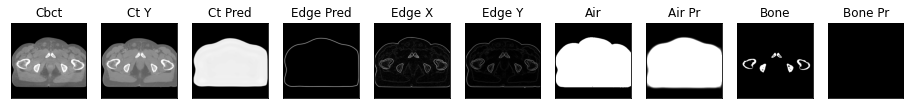

38it [00:14,  2.82it/s]

ssim score = 0.7913253903388977
psnr score = 19.762765884399414
snr score = 11.750201225280762
mae error = 0.05176743119955063
air dice score = 0.9890890248426423
bone dice score = 2.2311468094102822e-11
contour dice score = 0.13527478277683258


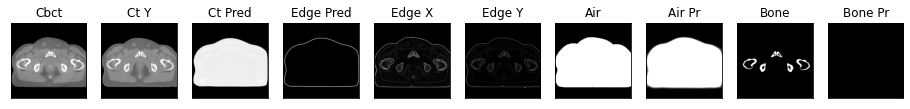

39it [00:14,  2.83it/s]

ssim score = 0.7830562591552734
psnr score = 19.44289779663086
snr score = 11.571621894836426
mae error = 0.053103361278772354
air dice score = 0.9892765656744167
bone dice score = 1.901140684374503e-11
contour dice score = 0.13364705443382263


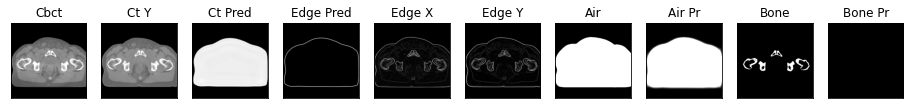

40it [00:15,  2.85it/s]

ssim score = 0.7718033790588379
psnr score = 19.163206100463867
snr score = 11.386617660522461
mae error = 0.055191028863191605
air dice score = 0.989783345615334
bone dice score = 1.5703517587693097e-11
contour dice score = 0.14703109860420227


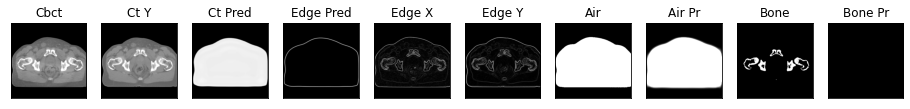

41it [00:15,  2.42it/s]

ssim score = 0.7583279013633728
psnr score = 19.326162338256836
snr score = 11.515525817871094
mae error = 0.05562623217701912
air dice score = 0.9896534191015681
bone dice score = 1.520450053192634e-11
contour dice score = 0.1718602478504181


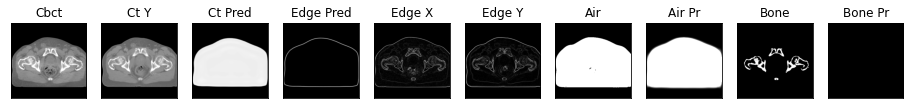

42it [00:16,  2.54it/s]

ssim score = 0.7366614937782288
psnr score = 18.399301528930664
snr score = 10.660850524902344
mae error = 0.061673231422901154
air dice score = 0.9905619317334979
bone dice score = 1.2884937507887064e-11
contour dice score = 0.11496437340974808


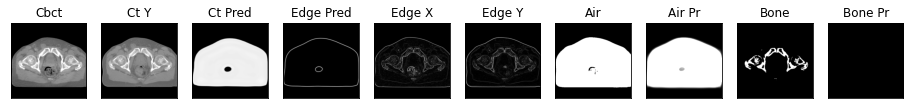

43it [00:16,  2.63it/s]

ssim score = 0.749207615852356
psnr score = 19.0555477142334
snr score = 11.181002616882324
mae error = 0.05684118717908859
air dice score = 0.9910338846188408
bone dice score = 1.669727834335119e-11
contour dice score = 0.1429252028465271


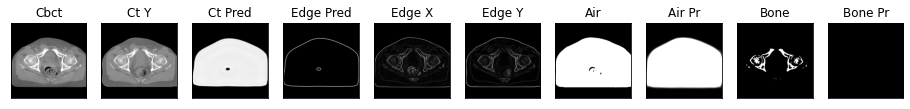

44it [00:16,  2.68it/s]

ssim score = 0.7595401406288147
psnr score = 19.538448333740234
snr score = 11.485342025756836
mae error = 0.05326225236058235
air dice score = 0.9911284811720049
bone dice score = 1.8821757951838475e-11
contour dice score = 0.1551724076271057


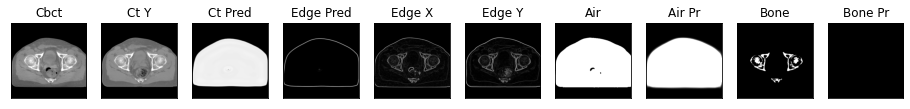

45it [00:17,  2.72it/s]

ssim score = 0.7795184254646301
psnr score = 19.966732025146484
snr score = 11.823038101196289
mae error = 0.05157559737563133
air dice score = 0.990443322009125
bone dice score = 2.1294718909256925e-11
contour dice score = 0.19001919031143188


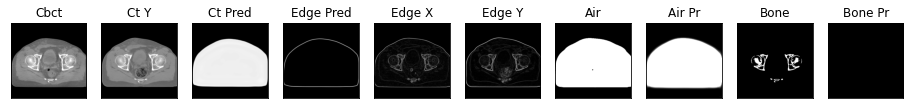

46it [00:17,  2.77it/s]

ssim score = 0.7868393063545227
psnr score = 19.77617835998535
snr score = 11.648172378540039
mae error = 0.052913591265678406
air dice score = 0.990904439428147
bone dice score = 1.983339944427145e-11
contour dice score = 0.20202019810676575


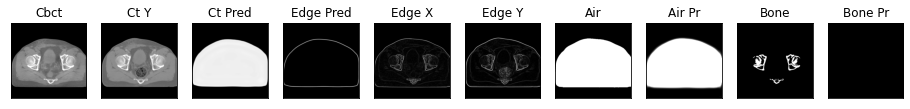

47it [00:17,  2.80it/s]

ssim score = 0.7890723943710327
psnr score = 19.56084442138672
snr score = 11.442875862121582
mae error = 0.05371691659092903
air dice score = 0.9911028797617805
bone dice score = 1.7966223499497554e-11
contour dice score = 0.20134875178337097


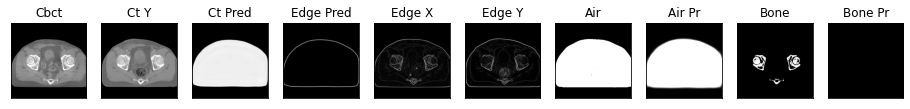

48it [00:18,  2.82it/s]

ssim score = 0.7949499487876892
psnr score = 19.231163024902344
snr score = 11.174783706665039
mae error = 0.0540178082883358
air dice score = 0.9911995675701992
bone dice score = 1.7488632388641332e-11
contour dice score = 0.20298220217227936


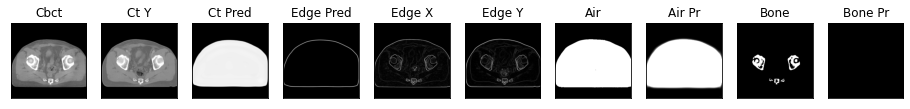

49it [00:18,  2.83it/s]

ssim score = 0.7991145849227905
psnr score = 19.089168548583984
snr score = 11.10287094116211
mae error = 0.05408336594700813
air dice score = 0.9911910632210202
bone dice score = 1.7155601303531385e-11
contour dice score = 0.2018260508775711


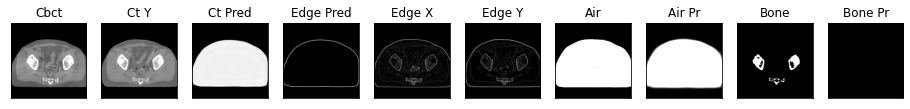

50it [00:18,  2.85it/s]

ssim score = 0.7907918095588684
psnr score = 19.4473934173584
snr score = 11.341991424560547
mae error = 0.05268246680498123
air dice score = 0.9906986647200227
bone dice score = 1.8978933383583622e-11
contour dice score = 0.19615384936332703


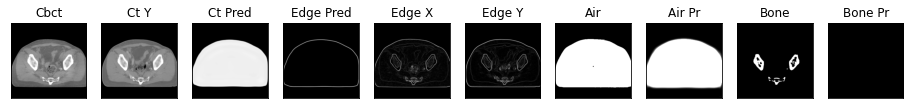

51it [00:19,  2.43it/s]

ssim score = 0.7824850082397461
psnr score = 18.974437713623047
snr score = 10.950661659240723
mae error = 0.05636608600616455
air dice score = 0.9896487872992807
bone dice score = 1.6531658125036674e-11
contour dice score = 0.1921776980161667


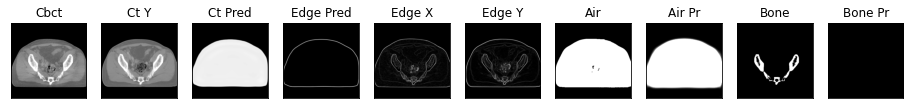

52it [00:19,  2.54it/s]

ssim score = 0.7571395039558411
psnr score = 18.373868942260742
snr score = 10.430240631103516
mae error = 0.06052463501691818
air dice score = 0.9904521970900253
bone dice score = 1.3825521913261087e-11
contour dice score = 0.1572815477848053


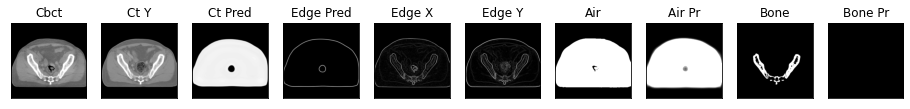

53it [00:20,  2.62it/s]

ssim score = 0.7441480159759521
psnr score = 18.32118797302246
snr score = 10.399116516113281
mae error = 0.061524007469415665
air dice score = 0.989548264211152
bone dice score = 1.3865779256601972e-11
contour dice score = 0.13742689788341522


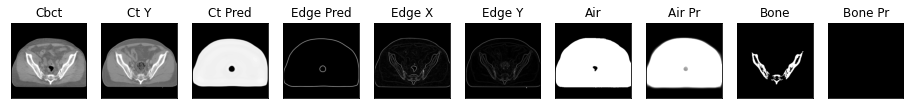

54it [00:20,  2.69it/s]

ssim score = 0.7618433237075806
psnr score = 18.96561050415039
snr score = 11.056076049804688
mae error = 0.057583339512348175
air dice score = 0.989634256200835
bone dice score = 1.4076576576378426e-11
contour dice score = 0.11159631609916687


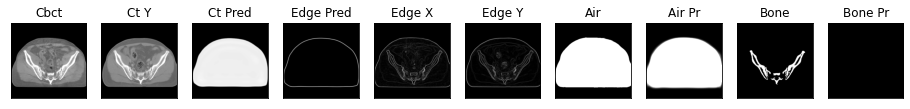

55it [00:20,  2.74it/s]

ssim score = 0.8415198922157288
psnr score = 20.873231887817383
snr score = 10.753440856933594
mae error = 0.03308216854929924
air dice score = 0.9862781938149593
bone dice score = 5.464480874018334e-11
contour dice score = 0.07070706784725189


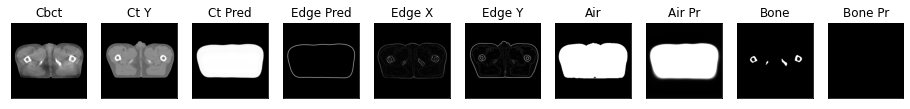

56it [00:21,  2.80it/s]

ssim score = 0.8342726826667786
psnr score = 20.366647720336914
snr score = 10.459836959838867
mae error = 0.03550410643219948
air dice score = 0.9857054400707778
bone dice score = 4.361098996757039e-11
contour dice score = 0.11613623797893524


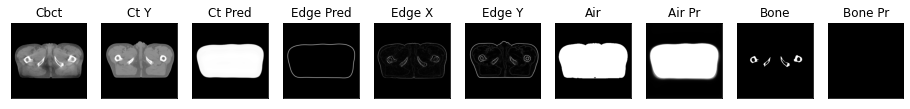

57it [00:21,  2.82it/s]

ssim score = 0.8271476030349731
psnr score = 20.177425384521484
snr score = 10.401754379272461
mae error = 0.036609549075365067
air dice score = 0.9846630083016878
bone dice score = 4.0933278753952794e-11
contour dice score = 0.1057906448841095


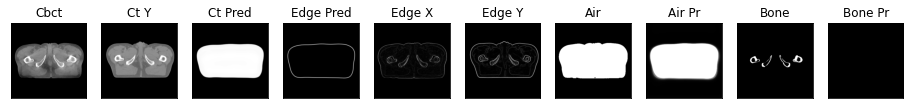

58it [00:21,  2.82it/s]

ssim score = 0.820615291595459
psnr score = 20.123186111450195
snr score = 10.417915344238281
mae error = 0.03736108914017677
air dice score = 0.9854222300048282
bone dice score = 3.9651070577333427e-11
contour dice score = 0.07555555552244186


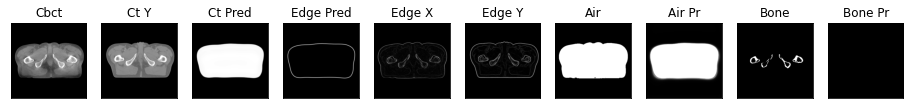

59it [00:22,  2.85it/s]

ssim score = 0.8161954283714294
psnr score = 20.062095642089844
snr score = 10.40439224243164
mae error = 0.03794126585125923
air dice score = 0.9851947553119182
bone dice score = 3.8197097019167415e-11
contour dice score = 0.06080707535147667


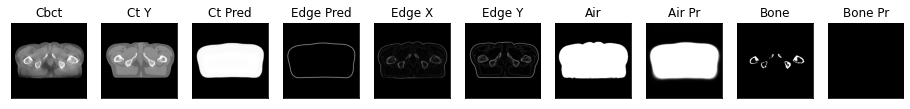

60it [00:22,  2.86it/s]

ssim score = 0.8138605356216431
psnr score = 19.923526763916016
snr score = 10.271439552307129
mae error = 0.03851301595568657
air dice score = 0.9839297677777628
bone dice score = 3.716090672474318e-11
contour dice score = 0.05714285746216774


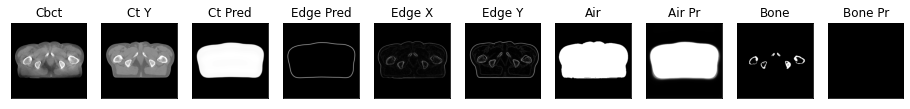

61it [00:23,  2.44it/s]

ssim score = 0.8086338043212891
psnr score = 19.80120277404785
snr score = 10.14261245727539
mae error = 0.03900246322154999
air dice score = 0.9837823766757917
bone dice score = 3.775009437381087e-11
contour dice score = 0.0713128075003624


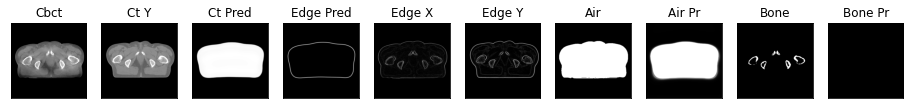

62it [00:23,  2.56it/s]

ssim score = 0.8088528513908386
psnr score = 19.795249938964844
snr score = 10.150771141052246
mae error = 0.03870813548564911
air dice score = 0.9837110481586543
bone dice score = 3.6968576708429996e-11
contour dice score = 0.08306364715099335


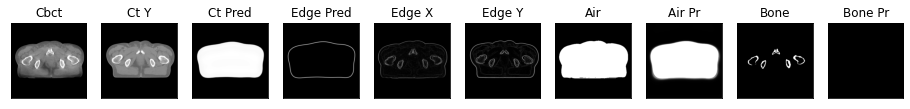

63it [00:23,  2.64it/s]

ssim score = 0.8050455451011658
psnr score = 19.6846981048584
snr score = 10.098223686218262
mae error = 0.038866009563207626
air dice score = 0.9842806363667872
bone dice score = 3.2733224221514463e-11
contour dice score = 0.07162235677242279


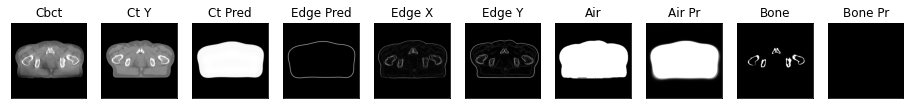

64it [00:24,  2.71it/s]

ssim score = 0.7993443608283997
psnr score = 19.401256561279297
snr score = 9.913341522216797
mae error = 0.04059063270688057
air dice score = 0.9850373635455896
bone dice score = 3.072196620489333e-11
contour dice score = 0.10193133354187012


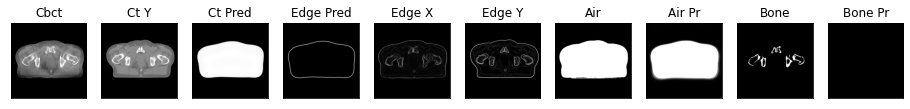

65it [00:24,  2.75it/s]

ssim score = 0.794521152973175
psnr score = 19.354887008666992
snr score = 9.902801513671875
mae error = 0.0413518026471138
air dice score = 0.9845339565576157
bone dice score = 2.928257686590681e-11
contour dice score = 0.04696886986494064


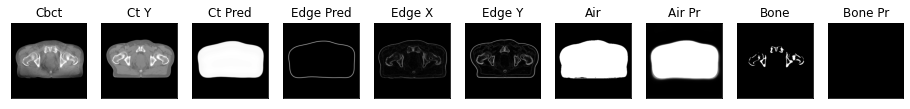

66it [00:24,  2.79it/s]

ssim score = 0.7897591590881348
psnr score = 19.39749526977539
snr score = 9.978116989135742
mae error = 0.0423024483025074
air dice score = 0.9846726215989295
bone dice score = 2.594706798064486e-11
contour dice score = 0.03917301446199417


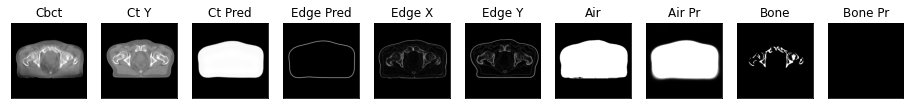

67it [00:25,  2.81it/s]

ssim score = 0.7852301597595215
psnr score = 19.201677322387695
snr score = 9.899115562438965
mae error = 0.04436921700835228
air dice score = 0.9844248516244258
bone dice score = 2.5980774226396966e-11
contour dice score = 0.036422066390514374


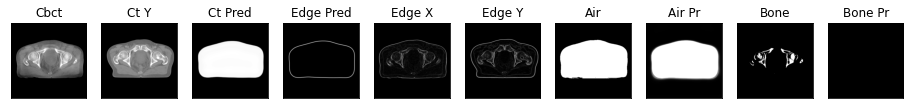

68it [00:25,  2.83it/s]

ssim score = 0.7856679558753967
psnr score = 19.242877960205078
snr score = 9.92432975769043
mae error = 0.044213030487298965
air dice score = 0.983723924800426
bone dice score = 2.884338044335612e-11
contour dice score = 0.05204872786998749


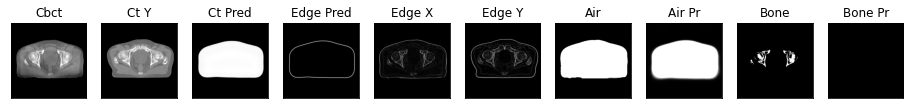

69it [00:25,  2.85it/s]

ssim score = 0.7977582216262817
psnr score = 19.761184692382812
snr score = 10.2434720993042
mae error = 0.040698714554309845
air dice score = 0.9840139963294077
bone dice score = 3.108486167139929e-11
contour dice score = 0.05024576559662819


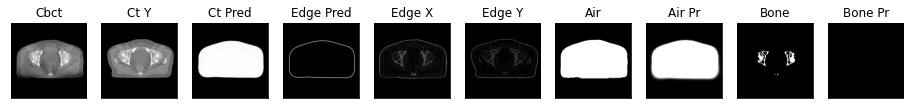

70it [00:26,  2.87it/s]

ssim score = 0.8115629553794861
psnr score = 20.232730865478516
snr score = 10.544628143310547
mae error = 0.03813817724585533
air dice score = 0.9842123748254759
bone dice score = 2.8546959747971826e-11
contour dice score = 0.04597701132297516


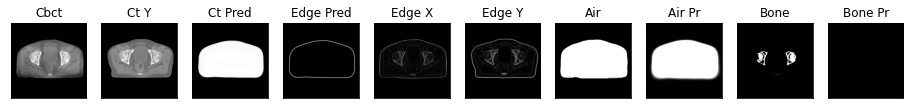

71it [00:26,  2.44it/s]

ssim score = 0.8160375952720642
psnr score = 20.215801239013672
snr score = 10.541866302490234
mae error = 0.03855931758880615
air dice score = 0.9845862189696382
bone dice score = 2.639915522633582e-11
contour dice score = 0.05422993376851082


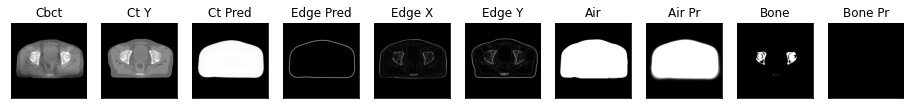

72it [00:27,  2.56it/s]

ssim score = 0.8193051815032959
psnr score = 20.063758850097656
snr score = 10.471651077270508
mae error = 0.03903042897582054
air dice score = 0.9845993969232997
bone dice score = 2.6759432699310692e-11
contour dice score = 0.027563394978642464


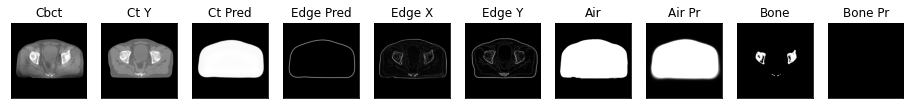

73it [00:27,  2.65it/s]

ssim score = 0.8220970630645752
psnr score = 19.92339324951172
snr score = 10.423458099365234
mae error = 0.03875337541103363
air dice score = 0.9844999405802892
bone dice score = 3.0321406912361387e-11
contour dice score = 0.021229051053524017


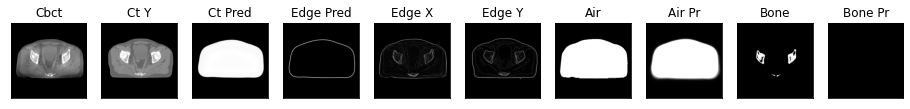

74it [00:27,  2.71it/s]

ssim score = 0.822104811668396
psnr score = 20.47812271118164
snr score = 10.91476058959961
mae error = 0.036784034222364426
air dice score = 0.9849743650484907
bone dice score = 3.331112591494633e-11
contour dice score = 0.029443837702274323


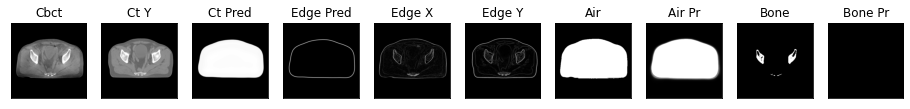

75it [00:28,  2.76it/s]

ssim score = 0.8209761381149292
psnr score = 20.72056007385254
snr score = 11.120804786682129
mae error = 0.03569731488823891
air dice score = 0.9836630568836616
bone dice score = 3.593244699834953e-11
contour dice score = 0.0627366155385971


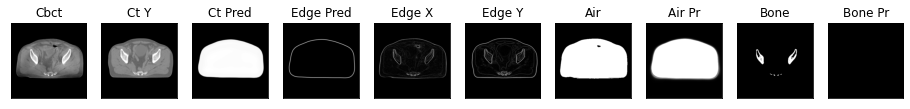

76it [00:28,  2.80it/s]

ssim score = 0.8123746514320374
psnr score = 20.74207305908203
snr score = 11.180063247680664
mae error = 0.036262910813093185
air dice score = 0.9828243630842055
bone dice score = 3.291639236231348e-11
contour dice score = 0.06892837584018707


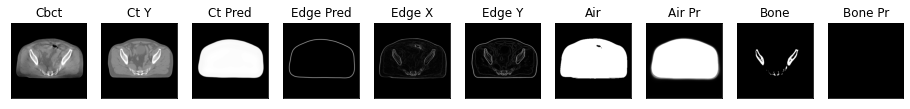

77it [00:28,  2.82it/s]

ssim score = 0.8020526766777039
psnr score = 20.367664337158203
snr score = 10.93616008758545
mae error = 0.03825032711029053
air dice score = 0.9852814438041931
bone dice score = 2.8481913983808548e-11
contour dice score = 0.06608884036540985


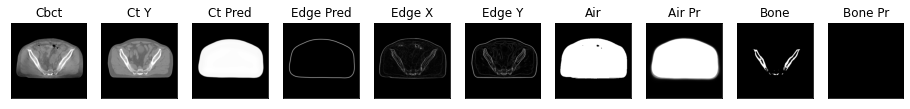

78it [00:29,  2.85it/s]

ssim score = 0.7969982624053955
psnr score = 20.303241729736328
snr score = 10.889486312866211
mae error = 0.03950713202357292
air dice score = 0.9848551583940498
bone dice score = 3.067484662482593e-11
contour dice score = 0.07847411185503006


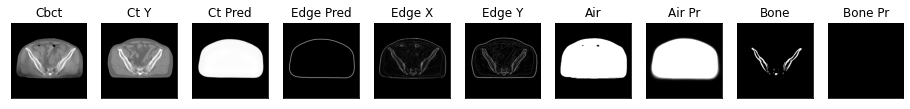

79it [00:29,  2.86it/s]

ssim score = 0.7974687218666077
psnr score = 20.44173812866211
snr score = 11.01671314239502
mae error = 0.03913048654794693
air dice score = 0.9859564658948938
bone dice score = 3.379520108030432e-11
contour dice score = 0.11281489580869675


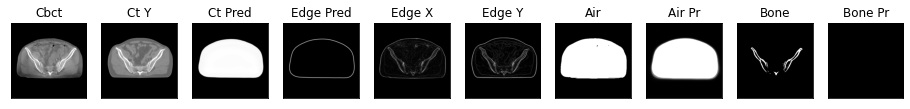

80it [00:29,  2.86it/s]

ssim score = 0.796505331993103
psnr score = 20.47168731689453
snr score = 11.045921325683594
mae error = 0.038760602474212646
air dice score = 0.9863811402273057
bone dice score = 3.257328990121911e-11
contour dice score = 0.10160132497549057


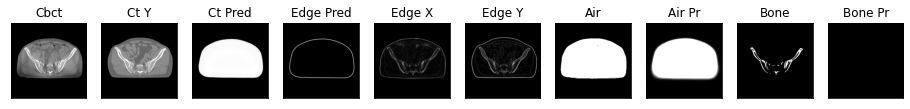

81it [00:30,  2.44it/s]

ssim score = 0.7951899170875549
psnr score = 19.655712127685547
snr score = 10.089847564697266
mae error = 0.04095574840903282
air dice score = 0.9818718279707978
bone dice score = 7.745933384372894e-11
contour dice score = 0.019543973729014397


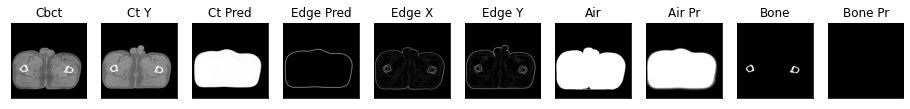

82it [00:30,  2.56it/s]

ssim score = 0.7907182574272156
psnr score = 19.703594207763672
snr score = 10.202120780944824
mae error = 0.040802616626024246
air dice score = 0.9822186074697938
bone dice score = 7.102272726768303e-11
contour dice score = 0.016120364889502525


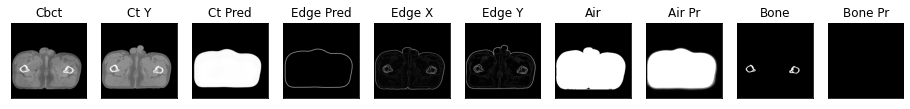

83it [00:31,  2.65it/s]

ssim score = 0.7893665432929993
psnr score = 19.939109802246094
snr score = 10.576848030090332
mae error = 0.04021938890218735
air dice score = 0.9829721240366356
bone dice score = 4.5372050814638294e-11
contour dice score = 0.022175289690494537


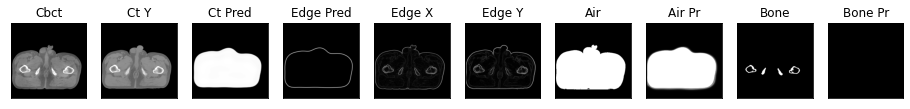

84it [00:31,  2.72it/s]

ssim score = 0.7867100834846497
psnr score = 20.009464263916016
snr score = 10.768695831298828
mae error = 0.039996128529310226
air dice score = 0.9842917185188786
bone dice score = 4.3668122268835455e-11
contour dice score = 0.04465709626674652


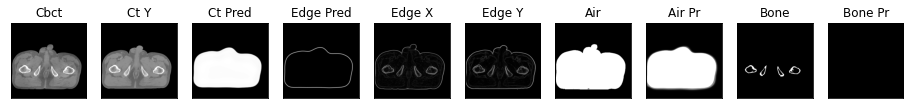

85it [00:31,  2.74it/s]

ssim score = 0.7830555438995361
psnr score = 20.263782501220703
snr score = 11.047183990478516
mae error = 0.039137281477451324
air dice score = 0.9859567865135357
bone dice score = 4.504504504301599e-11
contour dice score = 0.03957219421863556


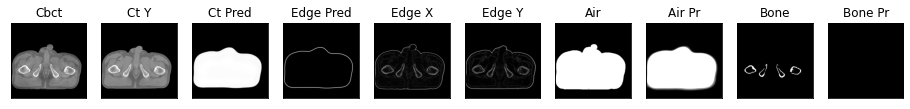

86it [00:32,  2.78it/s]

ssim score = 0.7832396626472473
psnr score = 20.465618133544922
snr score = 11.244625091552734
mae error = 0.03863915055990219
air dice score = 0.9872781065088857
bone dice score = 4.1101520754578645e-11
contour dice score = 0.02895442396402359


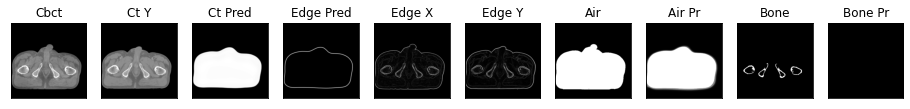

87it [00:32,  2.80it/s]

ssim score = 0.7857237458229065
psnr score = 20.457923889160156
snr score = 11.243185043334961
mae error = 0.03856169059872627
air dice score = 0.9880967199850718
bone dice score = 3.980891719586748e-11
contour dice score = 0.024744486436247826


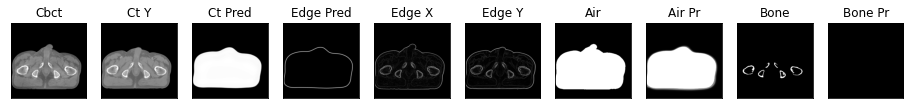

88it [00:32,  2.81it/s]

ssim score = 0.7861405611038208
psnr score = 20.433086395263672
snr score = 11.196792602539062
mae error = 0.038135647773742676
air dice score = 0.9889116276174481
bone dice score = 3.958828186699967e-11
contour dice score = 0.06434316188097


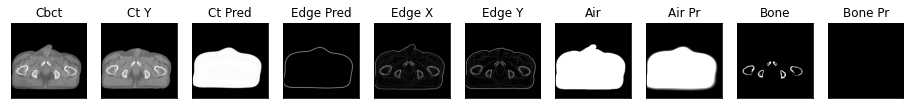

89it [00:33,  2.82it/s]

ssim score = 0.787121593952179
psnr score = 20.29060173034668
snr score = 11.071216583251953
mae error = 0.03879034146666527
air dice score = 0.9898748790913992
bone dice score = 3.700962250048077e-11
contour dice score = 0.0753498375415802


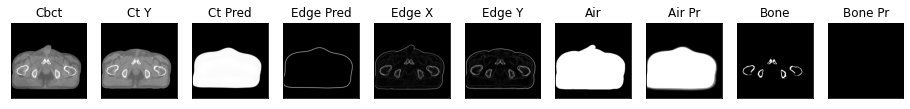

90it [00:33,  2.82it/s]

ssim score = 0.7835608124732971
psnr score = 20.164409637451172
snr score = 11.013617515563965
mae error = 0.03968813642859459
air dice score = 0.9911096837867334
bone dice score = 3.36134453770214e-11
contour dice score = 0.0810810774564743


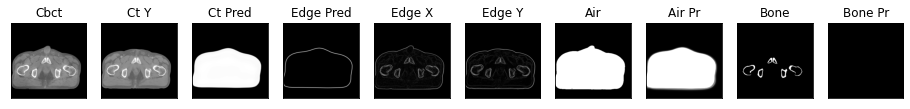

91it [00:34,  2.40it/s]

ssim score = 0.7777117490768433
psnr score = 20.13422203063965
snr score = 11.064788818359375
mae error = 0.040136680006980896
air dice score = 0.9919190013520801
bone dice score = 3.063725490102214e-11
contour dice score = 0.06507591903209686


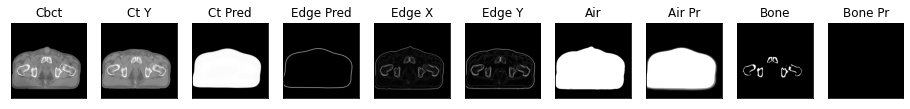

92it [00:34,  2.51it/s]

ssim score = 0.7728833556175232
psnr score = 20.13412857055664
snr score = 11.115398406982422
mae error = 0.040739573538303375
air dice score = 0.9917935768957691
bone dice score = 2.908667830049195e-11
contour dice score = 0.06185567006468773


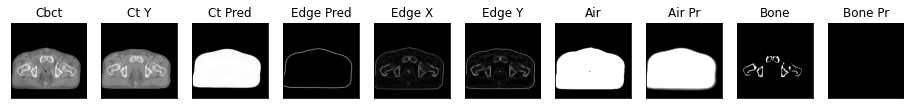

93it [00:34,  2.60it/s]

ssim score = 0.7692635655403137
psnr score = 19.895858764648438
snr score = 10.993396759033203
mae error = 0.04233471304178238
air dice score = 0.9933728746540187
bone dice score = 2.642007925953976e-11
contour dice score = 0.07166124135255814


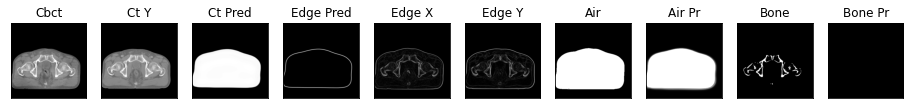

94it [00:35,  2.66it/s]

ssim score = 0.7689149379730225
psnr score = 20.08550262451172
snr score = 11.144804000854492
mae error = 0.04173756763339043
air dice score = 0.992448280238615
bone dice score = 2.8677946658196788e-11
contour dice score = 0.07065217196941376


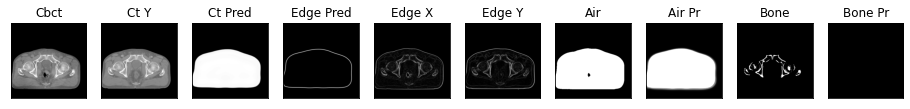

95it [00:35,  2.70it/s]

ssim score = 0.7700494527816772
psnr score = 19.879253387451172
snr score = 10.842886924743652
mae error = 0.04246556758880615
air dice score = 0.9888521553032207
bone dice score = 2.635046113237548e-11
contour dice score = 0.06004366651177406


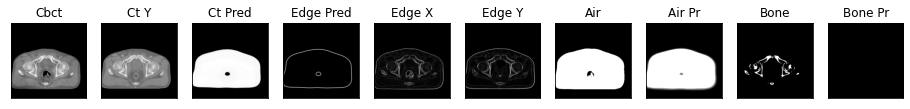

96it [00:35,  2.74it/s]

ssim score = 0.7764104008674622
psnr score = 19.874208450317383
snr score = 10.678083419799805
mae error = 0.041184134781360626
air dice score = 0.9859173053877881
bone dice score = 3.317850033068419e-11
contour dice score = 0.06239737197756767


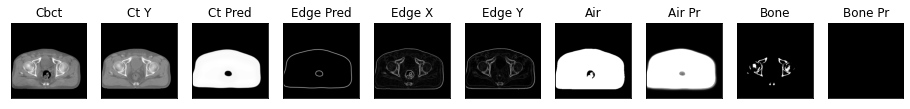

97it [00:36,  2.76it/s]

ssim score = 0.7818832397460938
psnr score = 19.915964126586914
snr score = 10.603414535522461
mae error = 0.04087477922439575
air dice score = 0.9838191910408349
bone dice score = 3.424657534129292e-11
contour dice score = 0.066006600856781


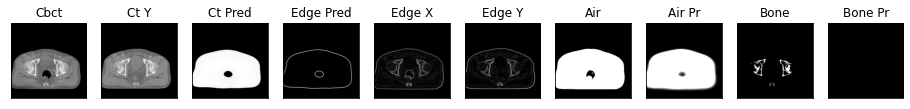

98it [00:36,  2.77it/s]

ssim score = 0.785452663898468
psnr score = 19.803293228149414
snr score = 10.445647239685059
mae error = 0.04213004186749458
air dice score = 0.9833188730826663
bone dice score = 3.183699458669733e-11
contour dice score = 0.06615214794874191


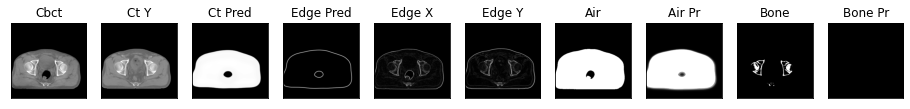

99it [00:37,  2.78it/s]

ssim score = 0.7845013737678528
psnr score = 19.474021911621094
snr score = 10.123051643371582
mae error = 0.043755143880844116
air dice score = 0.9838541538411159
bone dice score = 3.183699458669733e-11
contour dice score = 0.06512141227722168


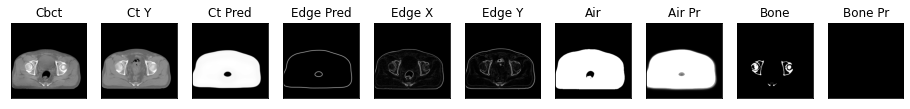

100it [00:37,  2.79it/s]

ssim score = 0.7855571508407593
psnr score = 19.298582077026367
snr score = 9.977713584899902
mae error = 0.044249046593904495
air dice score = 0.9851905482788248
bone dice score = 3.0012004801020045e-11
contour dice score = 0.06194690242409706


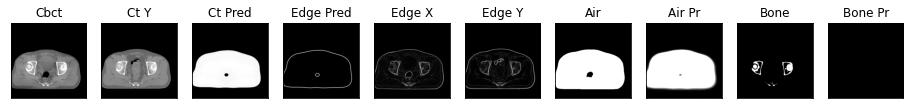

101it [00:37,  2.38it/s]

ssim score = 0.7888610363006592
psnr score = 19.406578063964844
snr score = 10.043123245239258
mae error = 0.04322316125035286
air dice score = 0.9889463626779216
bone dice score = 3.3333333332222224e-11
contour dice score = 0.06423034518957138


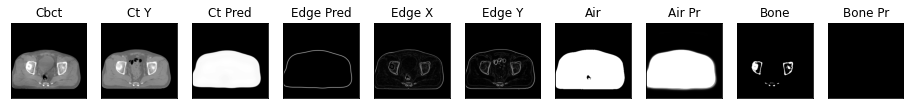

102it [00:38,  2.49it/s]

ssim score = 0.7854940295219421
psnr score = 19.379432678222656
snr score = 9.925773620605469
mae error = 0.043058477342128754
air dice score = 0.9879758353346009
bone dice score = 3.736920777139876e-11
contour dice score = 0.06637167930603027


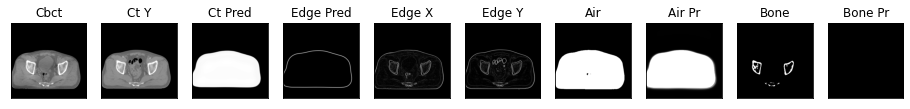

103it [00:38,  2.58it/s]

ssim score = 0.7847278118133545
psnr score = 19.456018447875977
snr score = 9.936634063720703
mae error = 0.04249689728021622
air dice score = 0.9865916266760579
bone dice score = 3.907776475032912e-11
contour dice score = 0.06651885062456131


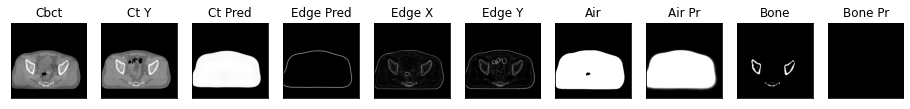

104it [00:39,  2.64it/s]

ssim score = 0.7817061543464661
psnr score = 19.381690979003906
snr score = 9.862004280090332
mae error = 0.042863957583904266
air dice score = 0.9845654763413466
bone dice score = 3.415300546331445e-11
contour dice score = 0.0789327397942543


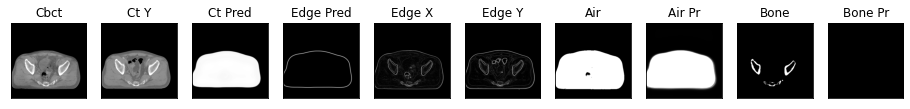

105it [00:39,  2.69it/s]

ssim score = 0.7762857675552368
psnr score = 19.222597122192383
snr score = 9.779078483581543
mae error = 0.044360630214214325
air dice score = 0.9821303732501389
bone dice score = 2.778549597033105e-11
contour dice score = 0.09715242683887482


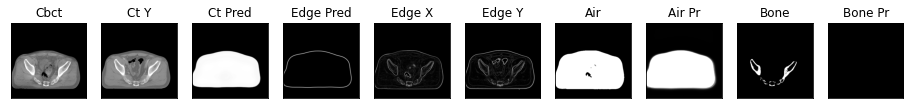

106it [00:39,  2.70it/s]

ssim score = 0.7750582695007324
psnr score = 19.099517822265625
snr score = 9.691579818725586
mae error = 0.04570353776216507
air dice score = 0.9824570437887443
bone dice score = 2.5906735750624178e-11
contour dice score = 0.1004464253783226


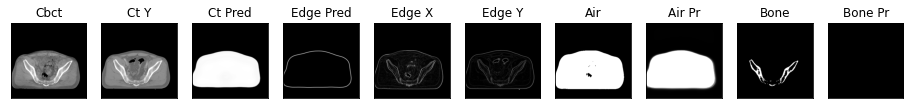

107it [00:40,  2.73it/s]

ssim score = 0.7758577466011047
psnr score = 19.162599563598633
snr score = 9.692963600158691
mae error = 0.04565982520580292
air dice score = 0.9827870907503455
bone dice score = 2.7639579877621902e-11
contour dice score = 0.10538116842508316


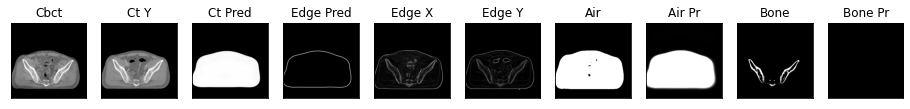

108it [00:40,  2.76it/s]

ssim score = 0.7774218320846558
psnr score = 19.174514770507812
snr score = 9.643616676330566
mae error = 0.04556705430150032
air dice score = 0.9804106844449282
bone dice score = 2.894356005704939e-11
contour dice score = 0.06704545766115189


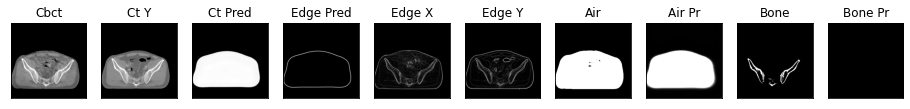

109it [00:40,  2.77it/s]

ssim score = 0.8016366362571716
psnr score = 19.864059448242188
snr score = 11.56136417388916
mae error = 0.048569455742836
air dice score = 0.9890915107607643
bone dice score = 6.325110689036994e-11
contour dice score = 0.1625794768333435


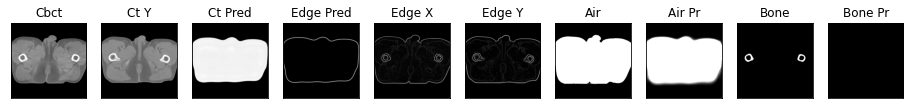

110it [00:41,  2.78it/s]

ssim score = 0.7994289398193359
psnr score = 20.008459091186523
snr score = 11.81005859375
mae error = 0.04810809716582298
air dice score = 0.9894675008077132
bone dice score = 5.681818181495351e-11
contour dice score = 0.1553839147090912


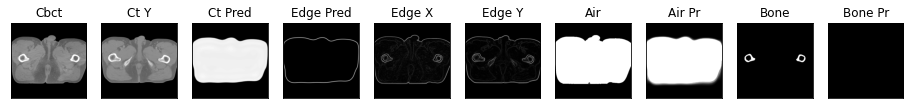

111it [00:41,  2.38it/s]

ssim score = 0.7906588912010193
psnr score = 19.830312728881836
snr score = 11.759867668151855
mae error = 0.04907434061169624
air dice score = 0.9904011612253794
bone dice score = 4.559963520083905e-11
contour dice score = 0.1666666716337204


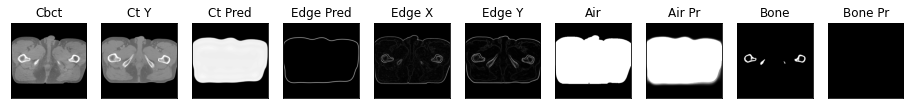

112it [00:42,  2.48it/s]

ssim score = 0.7848387360572815
psnr score = 19.82062339782715
snr score = 11.782466888427734
mae error = 0.049259088933467865
air dice score = 0.9913448191393861
bone dice score = 3.344481605239315e-11
contour dice score = 0.16317228972911835


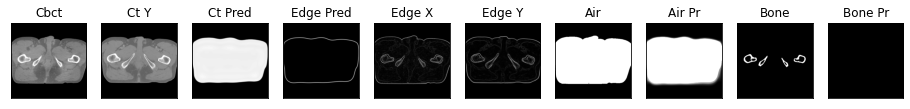

113it [00:42,  2.57it/s]

ssim score = 0.7797004580497742
psnr score = 19.668987274169922
snr score = 11.661069869995117
mae error = 0.050494249910116196
air dice score = 0.9913692830223844
bone dice score = 3.231017770493343e-11
contour dice score = 0.1636945605278015


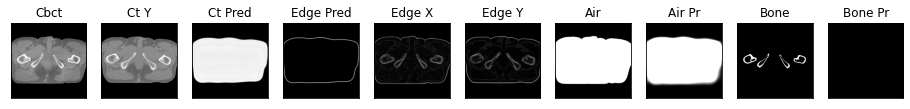

114it [00:42,  2.64it/s]

ssim score = 0.7752755880355835
psnr score = 19.530662536621094
snr score = 11.557160377502441
mae error = 0.051557280123233795
air dice score = 0.9911082018872676
bone dice score = 3.0684258974204225e-11
contour dice score = 0.16933637857437134


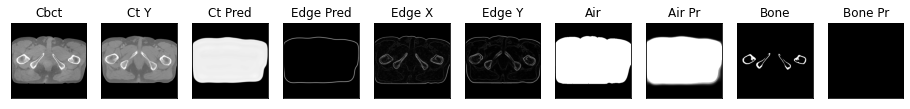

115it [00:43,  2.69it/s]

ssim score = 0.7763966917991638
psnr score = 19.428987503051758
snr score = 11.475796699523926
mae error = 0.051738664507865906
air dice score = 0.9912624214915645
bone dice score = 2.6874496102475827e-11
contour dice score = 0.18886861205101013


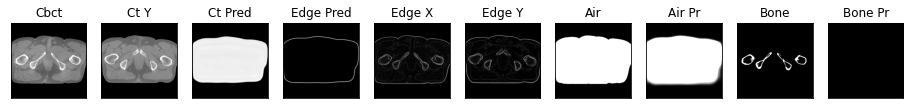

116it [00:43,  2.73it/s]

ssim score = 0.7689263224601746
psnr score = 19.245243072509766
snr score = 11.331124305725098
mae error = 0.05238090828061104
air dice score = 0.9909483006498413
bone dice score = 2.6659557450635575e-11
contour dice score = 0.20914441347122192


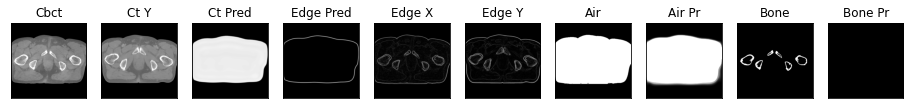

117it [00:43,  2.75it/s]

ssim score = 0.7636117339134216
psnr score = 19.110090255737305
snr score = 11.244651794433594
mae error = 0.0530816949903965
air dice score = 0.9916724177593791
bone dice score = 2.57731958756244e-11
contour dice score = 0.19465146958827972


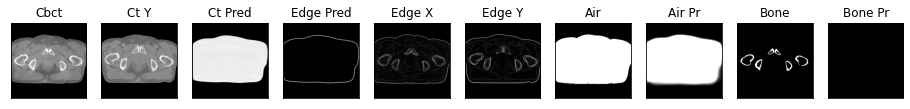

118it [00:44,  2.76it/s]

ssim score = 0.7568309307098389
psnr score = 19.18622589111328
snr score = 11.34339714050293
mae error = 0.05289850011467934
air dice score = 0.9913451260301419
bone dice score = 2.4801587300972182e-11
contour dice score = 0.1932159662246704


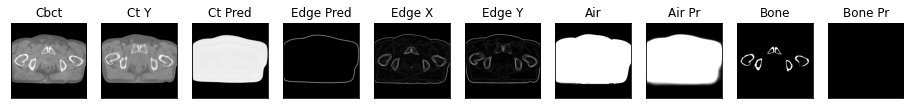

119it [00:44,  2.78it/s]

ssim score = 0.7457970976829529
psnr score = 19.20808982849121
snr score = 11.408041000366211
mae error = 0.05377965047955513
air dice score = 0.9906502410529567
bone dice score = 2.3110700253683597e-11
contour dice score = 0.18814432621002197


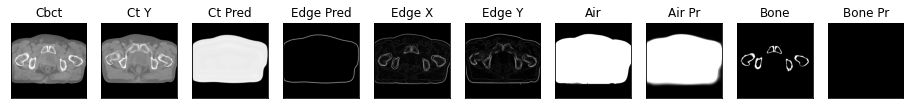

120it [00:44,  2.79it/s]

ssim score = 0.7491764426231384
psnr score = 19.19553565979004
snr score = 11.453824996948242
mae error = 0.05498334392905235
air dice score = 0.9912854652990135
bone dice score = 2.1083702297679026e-11
contour dice score = 0.19615031778812408


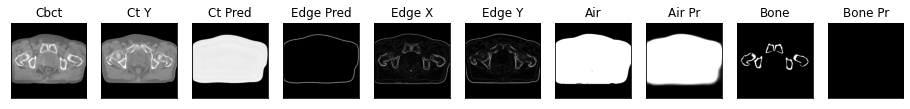

121it [00:45,  2.38it/s]

ssim score = 0.7508330941200256
psnr score = 19.24944305419922
snr score = 11.432360649108887
mae error = 0.054735615849494934
air dice score = 0.9910243233984293
bone dice score = 1.9051247856371665e-11
contour dice score = 0.18683847784996033


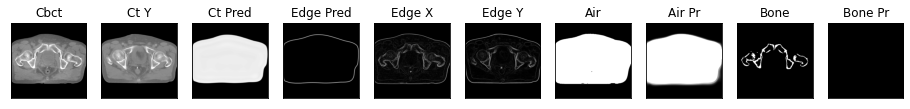

122it [00:45,  2.49it/s]

ssim score = 0.7550374269485474
psnr score = 19.317914962768555
snr score = 11.3936128616333
mae error = 0.054486893117427826
air dice score = 0.9909604519774063
bone dice score = 1.8545994064937944e-11
contour dice score = 0.18173432350158691


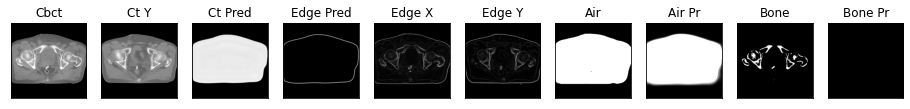

123it [00:46,  2.58it/s]

ssim score = 0.764849066734314
psnr score = 19.44088363647461
snr score = 11.393494606018066
mae error = 0.054391682147979736
air dice score = 0.990664350846727
bone dice score = 1.9391118867182643e-11
contour dice score = 0.17407406866550446


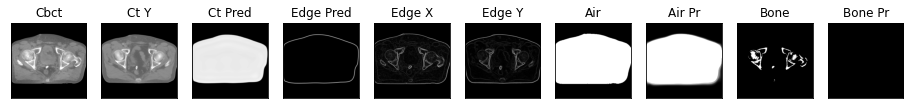

124it [00:46,  2.64it/s]

ssim score = 0.7736935615539551
psnr score = 19.457427978515625
snr score = 11.297608375549316
mae error = 0.055065978318452835
air dice score = 0.9901153401216454
bone dice score = 2.0395676116247285e-11
contour dice score = 0.17023256421089172


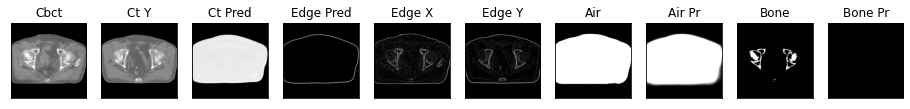

125it [00:46,  2.71it/s]

ssim score = 0.7751768827438354
psnr score = 19.457738876342773
snr score = 11.247273445129395
mae error = 0.055484965443611145
air dice score = 0.9906974607513289
bone dice score = 2.0104543626455478e-11
contour dice score = 0.16448597609996796


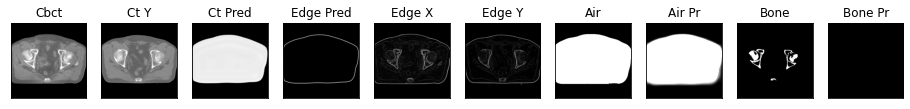

126it [00:47,  2.75it/s]

ssim score = 0.7768194675445557
psnr score = 19.41280174255371
snr score = 11.234491348266602
mae error = 0.05525892600417137
air dice score = 0.9900773299835256
bone dice score = 2.1263023601504083e-11
contour dice score = 0.14178404211997986


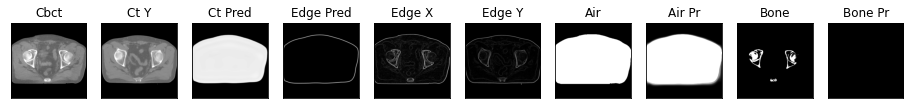

127it [00:47,  2.78it/s]

ssim score = 0.7757977247238159
psnr score = 19.327226638793945
snr score = 11.162393569946289
mae error = 0.05479959771037102
air dice score = 0.9893255308322215
bone dice score = 2.2983222247230908e-11
contour dice score = 0.13793103396892548


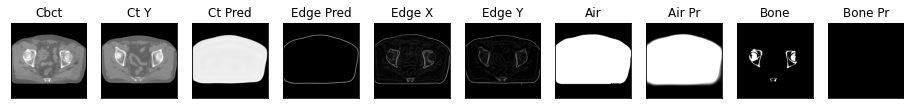

128it [00:47,  2.80it/s]

ssim score = 0.7795339226722717
psnr score = 19.72414779663086
snr score = 11.41782283782959
mae error = 0.05285384878516197
air dice score = 0.988922468906202
bone dice score = 2.2810218977581884e-11
contour dice score = 0.13498099148273468


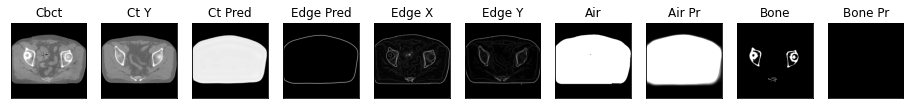

129it [00:48,  2.81it/s]

ssim score = 0.7839093208312988
psnr score = 19.859895706176758
snr score = 11.494260787963867
mae error = 0.05184679478406906
air dice score = 0.9894445385563555
bone dice score = 2.6745119015064317e-11
contour dice score = 0.1335877925157547


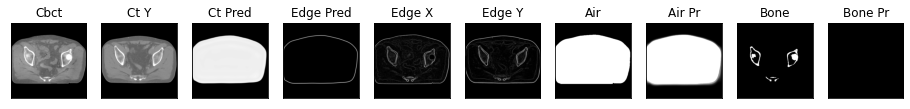

130it [00:48,  2.82it/s]

ssim score = 0.7840413451194763
psnr score = 19.905723571777344
snr score = 11.565736770629883
mae error = 0.049960605800151825
air dice score = 0.9896816401317898
bone dice score = 3.707823507463559e-11
contour dice score = 0.1279236227273941


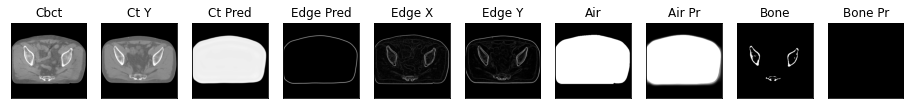

131it [00:49,  2.42it/s]

ssim score = 0.7834547162055969
psnr score = 19.830093383789062
snr score = 11.562920570373535
mae error = 0.04957029968500137
air dice score = 0.9896129203696657
bone dice score = 3.449465332754417e-11
contour dice score = 0.12422360479831696


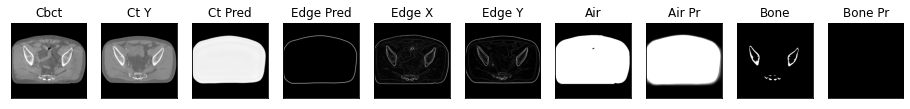

132it [00:49,  2.54it/s]

ssim score = 0.7728351950645447
psnr score = 19.51506805419922
snr score = 11.37712574005127
mae error = 0.05155942961573601
air dice score = 0.9907554571375903
bone dice score = 3.211303789235347e-11
contour dice score = 0.10902073979377747


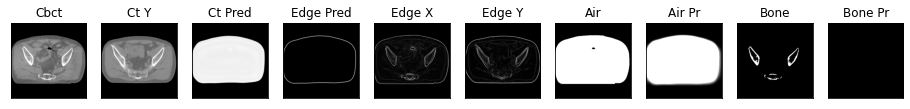

133it [00:49,  2.62it/s]

ssim score = 0.764904260635376
psnr score = 19.59129524230957
snr score = 11.487312316894531
mae error = 0.0511702224612236
air dice score = 0.9904347774004454
bone dice score = 2.913752913668014e-11
contour dice score = 0.09888511896133423


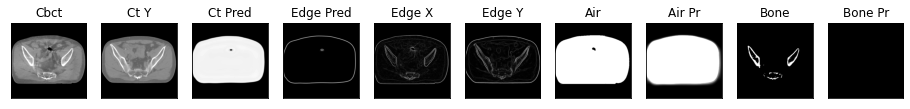

134it [00:50,  2.69it/s]

ssim score = 0.7697378993034363
psnr score = 19.905269622802734
snr score = 11.77149772644043
mae error = 0.04947884753346443
air dice score = 0.9899588516861272
bone dice score = 2.358490565982111e-11
contour dice score = 0.10378273576498032


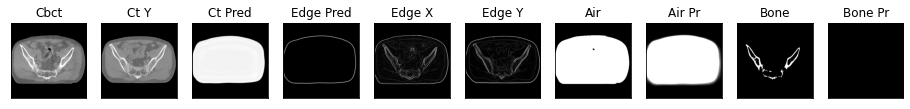

135it [00:50,  2.74it/s]

ssim score = 0.77096027135849
psnr score = 20.0229434967041
snr score = 11.825794219970703
mae error = 0.04858581721782684
air dice score = 0.989200837928301
bone dice score = 2.581311306076889e-11
contour dice score = 0.10204081982374191


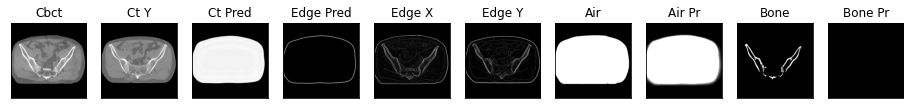

136it [00:50,  2.78it/s]

ssim score = 0.7641225457191467
psnr score = 19.114604949951172
snr score = 10.591995239257812
mae error = 0.0462423600256443
air dice score = 0.9894514767932567
bone dice score = 2.3546032492970425e-11
contour dice score = 0.020304568111896515


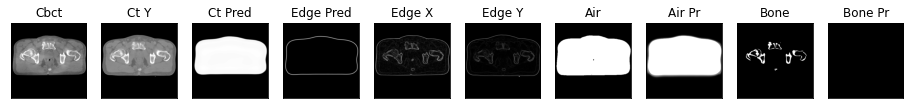

137it [00:51,  2.80it/s]

ssim score = 0.7596570253372192
psnr score = 19.110158920288086
snr score = 10.627561569213867
mae error = 0.04654448851943016
air dice score = 0.9890025481000119
bone dice score = 2.4479804160967446e-11
contour dice score = 0.014249363914132118


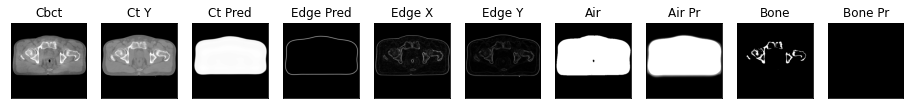

138it [00:51,  2.83it/s]

ssim score = 0.7596513032913208
psnr score = 19.127784729003906
snr score = 10.652973175048828
mae error = 0.04665270447731018
air dice score = 0.9893020434132923
bone dice score = 2.5484199795476957e-11
contour dice score = 0.00817577913403511


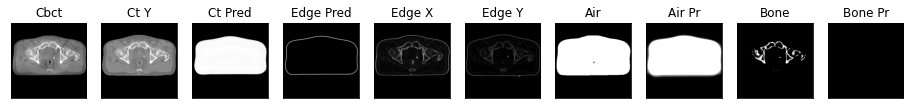

139it [00:52,  2.84it/s]

ssim score = 0.7656323313713074
psnr score = 19.207597732543945
snr score = 10.674367904663086
mae error = 0.0457846075296402
air dice score = 0.9884295313960301
bone dice score = 2.427184465960505e-11
contour dice score = 0.00716845877468586


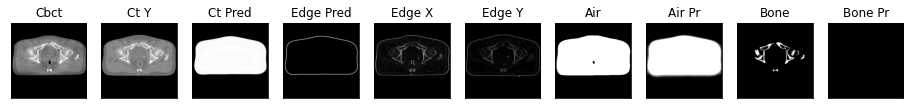

140it [00:52,  2.84it/s]

ssim score = 0.7764490842819214
psnr score = 19.444005966186523
snr score = 10.755151748657227
mae error = 0.04302922263741493
air dice score = 0.9879557485279338
bone dice score = 2.960331557046764e-11
contour dice score = 0.006169665604829788


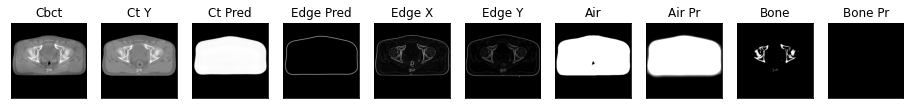

141it [00:52,  2.42it/s]

ssim score = 0.7796081304550171
psnr score = 19.373247146606445
snr score = 10.663590431213379
mae error = 0.043165337294340134
air dice score = 0.9886970266320803
bone dice score = 2.7601435273872442e-11
contour dice score = 0.017534811049699783


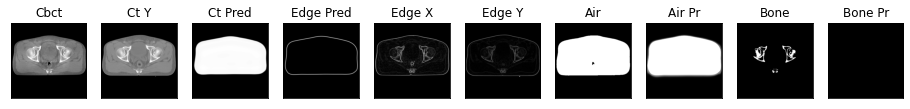

142it [00:53,  2.54it/s]

ssim score = 0.784701943397522
psnr score = 19.330469131469727
snr score = 10.605181694030762
mae error = 0.04338901862502098
air dice score = 0.9890363185978543
bone dice score = 2.7352297592249663e-11
contour dice score = 0.02382185310125351


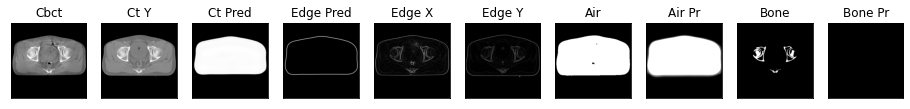

143it [00:53,  2.64it/s]

ssim score = 0.7864404320716858
psnr score = 19.071462631225586
snr score = 10.35554027557373
mae error = 0.04485128074884415
air dice score = 0.9889593222375856
bone dice score = 2.7210884353001064e-11
contour dice score = 0.03532467409968376


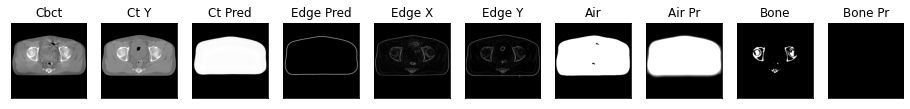

144it [00:53,  2.70it/s]

ssim score = 0.7863319516181946
psnr score = 18.8167724609375
snr score = 10.156630516052246
mae error = 0.046132054179906845
air dice score = 0.9899355149762024
bone dice score = 2.6666666665955555e-11
contour dice score = 0.023983316496014595


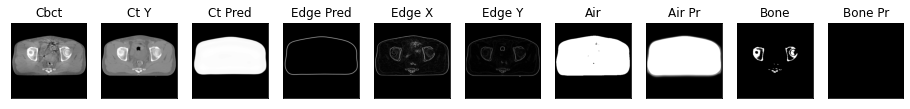

145it [00:54,  2.74it/s]

ssim score = 0.7839831709861755
psnr score = 18.64162826538086
snr score = 9.959555625915527
mae error = 0.04687623307108879
air dice score = 0.9896910335438568
bone dice score = 2.7389756230419344e-11
contour dice score = 0.020942408591508865


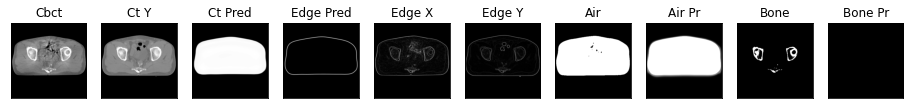

146it [00:54,  2.77it/s]

ssim score = 0.7821430563926697
psnr score = 18.626863479614258
snr score = 9.874018669128418
mae error = 0.046622276306152344
air dice score = 0.9892513900372528
bone dice score = 3.041362530321127e-11
contour dice score = 0.026288118213415146


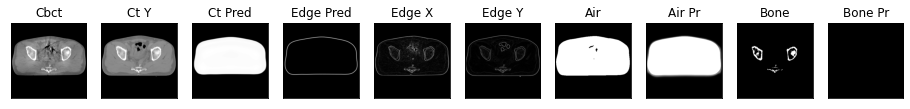

147it [00:55,  2.80it/s]

ssim score = 0.780347466468811
psnr score = 18.69512176513672
snr score = 9.898384094238281
mae error = 0.04612719267606735
air dice score = 0.9905980892155518
bone dice score = 3.231017770493343e-11
contour dice score = 0.0263713076710701


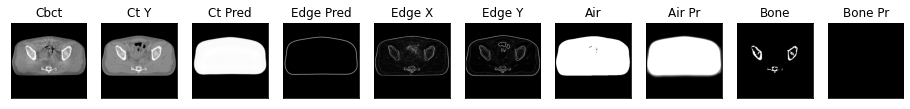

148it [00:55,  2.80it/s]

ssim score = 0.7805876135826111
psnr score = 18.777912139892578
snr score = 9.980073928833008
mae error = 0.04537476599216461
air dice score = 0.9900638263800529
bone dice score = 3.127932436561528e-11
contour dice score = 0.017998941242694855


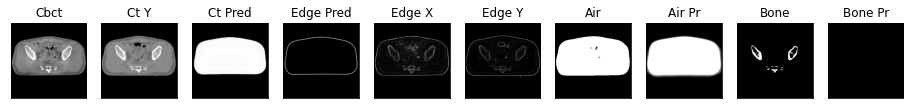

149it [00:55,  2.82it/s]

ssim score = 0.7783104181289673
psnr score = 18.863327026367188
snr score = 10.078848838806152
mae error = 0.045365117490291595
air dice score = 0.9889642294093421
bone dice score = 2.999400119886041e-11
contour dice score = 0.020148461684584618


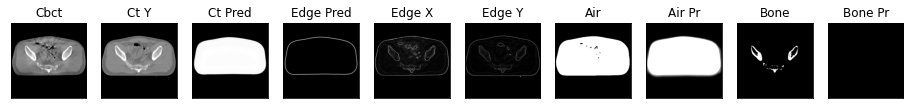

150it [00:56,  2.83it/s]

ssim score = 0.7717038989067078
psnr score = 18.762271881103516
snr score = 10.032998085021973
mae error = 0.04615078121423721
air dice score = 0.9874175693415624
bone dice score = 2.501250625250094e-11
contour dice score = 0.02231668494641781


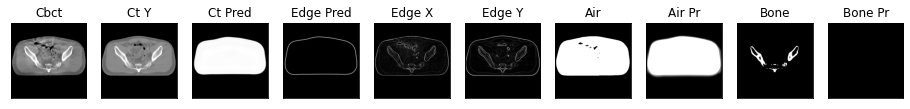

151it [00:56,  2.42it/s]

ssim score = 0.7678132057189941
psnr score = 18.6235294342041
snr score = 9.91362476348877
mae error = 0.04740120470523834
air dice score = 0.9872511123577471
bone dice score = 2.5595085742882133e-11
contour dice score = 0.03723404183983803


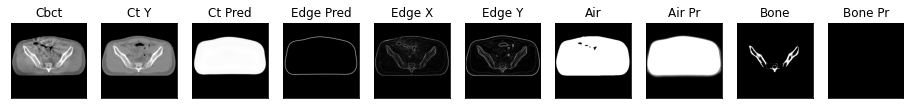

152it [00:56,  2.54it/s]

ssim score = 0.7650198936462402
psnr score = 18.504268646240234
snr score = 9.739624977111816
mae error = 0.048683881759643555
air dice score = 0.9882381901120886
bone dice score = 2.8042624788893925e-11
contour dice score = 0.024533333256840706


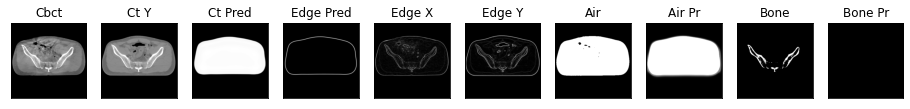

153it [00:57,  2.64it/s]

ssim score = 0.7612139582633972
psnr score = 18.449556350708008
snr score = 9.648560523986816
mae error = 0.04936056211590767
air dice score = 0.9893238981616881
bone dice score = 2.801120448100809e-11
contour dice score = 0.012847965583205223


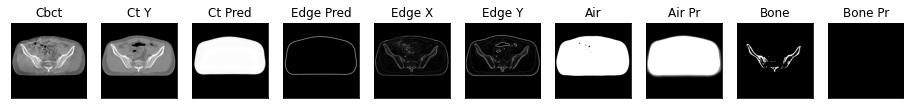

154it [00:57,  2.70it/s]

ssim score = 0.7603796720504761
psnr score = 18.389846801757812
snr score = 9.588922500610352
mae error = 0.05008641257882118
air dice score = 0.9895422621981352
bone dice score = 2.5252525251887564e-11
contour dice score = 0.005376344081014395


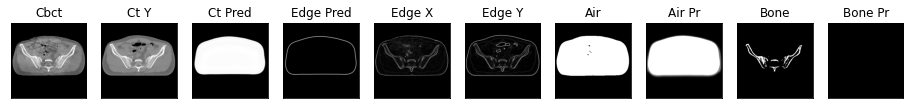

155it [00:58,  2.75it/s]

ssim score = 0.7596325278282166
psnr score = 18.56979751586914
snr score = 9.767454147338867
mae error = 0.04973285645246506
air dice score = 0.989142002251809
bone dice score = 2.552322613513213e-11
contour dice score = 0.04437229409813881


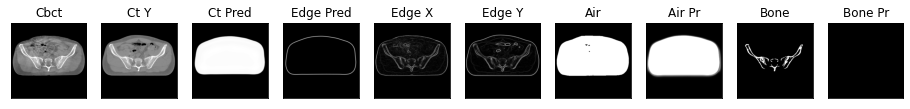

156it [00:58,  2.78it/s]

ssim score = 0.7581566572189331
psnr score = 18.537994384765625
snr score = 9.74068832397461
mae error = 0.049833349883556366
air dice score = 0.9877815193549478
bone dice score = 2.570033410368285e-11
contour dice score = 0.05105920881032944


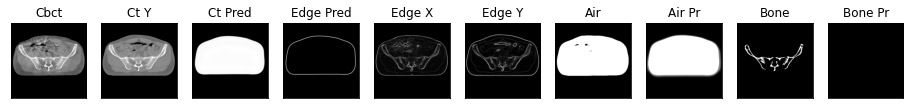

157it [00:58,  2.80it/s]

ssim score = 0.7565054297447205
psnr score = 18.403017044067383
snr score = 9.588436126708984
mae error = 0.05112093687057495
air dice score = 0.9840545636537287
bone dice score = 2.5753283542988583e-11
contour dice score = 0.06994535773992538


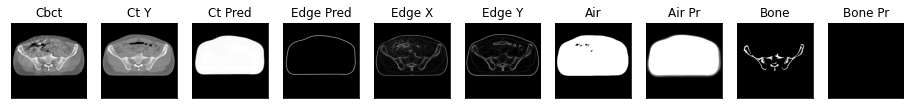

158it [00:59,  2.83it/s]

ssim score = 0.7520642280578613
psnr score = 18.178136825561523
snr score = 9.344935417175293
mae error = 0.053218647837638855
air dice score = 0.9847472818674372
bone dice score = 2.3992322456238187e-11
contour dice score = 0.06934507191181183


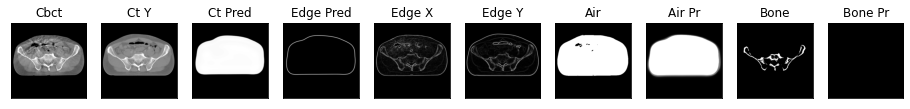

159it [00:59,  2.84it/s]

ssim score = 0.7463857531547546
psnr score = 18.041101455688477
snr score = 9.161958694458008
mae error = 0.0546170175075531
air dice score = 0.9845031619811029
bone dice score = 2.3137436371514637e-11
contour dice score = 0.07513812184333801


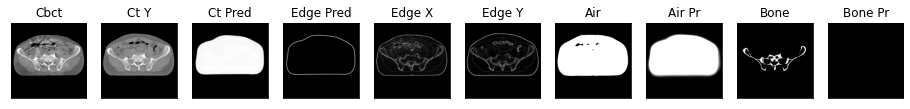

160it [00:59,  2.85it/s]

ssim score = 0.7471470832824707
psnr score = 18.030574798583984
snr score = 9.097635269165039
mae error = 0.05522926524281502
air dice score = 0.9825531914893755
bone dice score = 2.277385561323676e-11
contour dice score = 0.03116304986178875


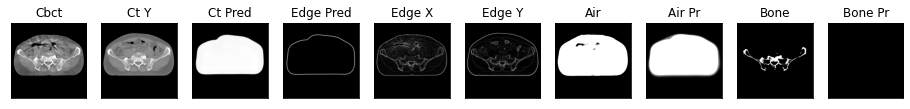

161it [01:00,  2.43it/s]

ssim score = 0.7441540956497192
psnr score = 17.819374084472656
snr score = 8.916899681091309
mae error = 0.0569874569773674
air dice score = 0.9821374938745971
bone dice score = 2.228660574944759e-11
contour dice score = 0.025741465389728546


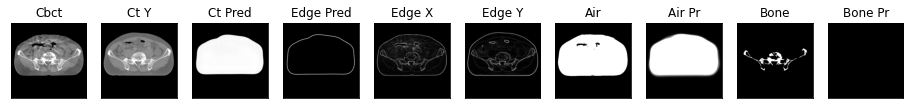

162it [01:00,  2.55it/s]

ssim score = 0.7440634369850159
psnr score = 17.738502502441406
snr score = 8.780799865722656
mae error = 0.05736090615391731
air dice score = 0.9832042468018583
bone dice score = 2.3148148147612312e-11
contour dice score = 0.026830632239580154


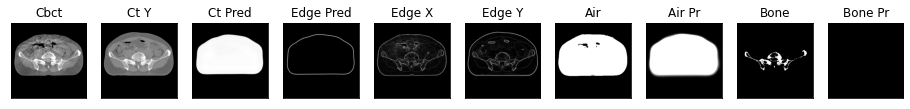

163it [01:01,  2.63it/s]

ssim score = 0.75508052110672
psnr score = 18.20088005065918
snr score = 9.095645904541016
mae error = 0.05396684631705284
air dice score = 0.9849648441516448
bone dice score = 2.4425989251968098e-11
contour dice score = 0.05053340643644333


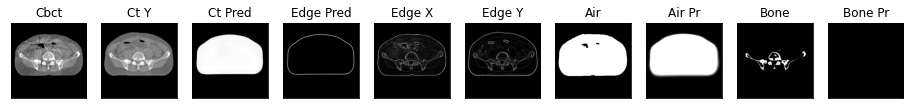

164it [01:01,  2.70it/s]

ssim score = 0.80318683385849
psnr score = 20.536710739135742
snr score = 10.917624473571777
mae error = 0.04513472691178322
air dice score = 0.9863557757129977
bone dice score = 5.515719801129855e-11
contour dice score = 0.16470588743686676


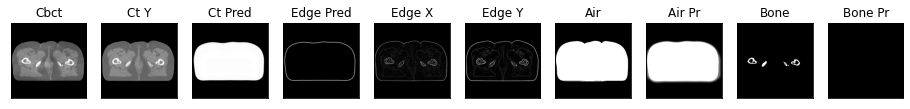

165it [01:01,  2.75it/s]

ssim score = 0.7987542748451233
psnr score = 20.440204620361328
snr score = 10.942127227783203
mae error = 0.045498378574848175
air dice score = 0.9863482222125294
bone dice score = 4.6554934820923885e-11
contour dice score = 0.17782217264175415


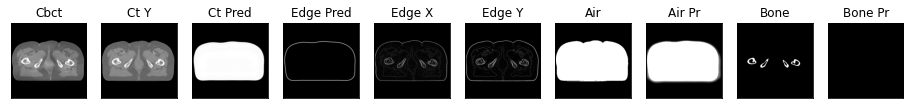

166it [01:02,  2.79it/s]

ssim score = 0.7925549149513245
psnr score = 20.422271728515625
snr score = 11.007112503051758
mae error = 0.04555284604430199
air dice score = 0.9860887053019278
bone dice score = 4.1666666664930555e-11
contour dice score = 0.15794669091701508


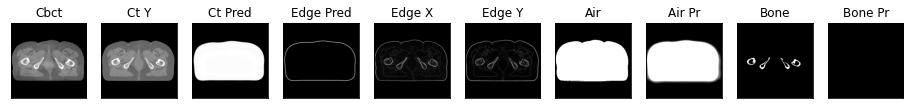

167it [01:02,  2.80it/s]

ssim score = 0.7887805104255676
psnr score = 20.328914642333984
snr score = 10.977201461791992
mae error = 0.046108294278383255
air dice score = 0.9861329109367225
bone dice score = 3.703703703566529e-11
contour dice score = 0.1379990130662918


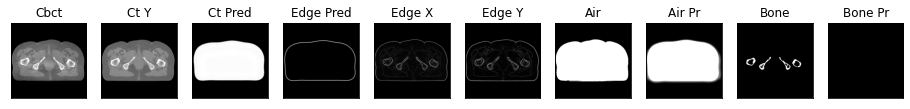

168it [01:02,  2.81it/s]

ssim score = 0.7876657247543335
psnr score = 20.226032257080078
snr score = 10.902780532836914
mae error = 0.04679976776242256
air dice score = 0.9860561914672317
bone dice score = 3.527336860545773e-11
contour dice score = 0.1381709724664688


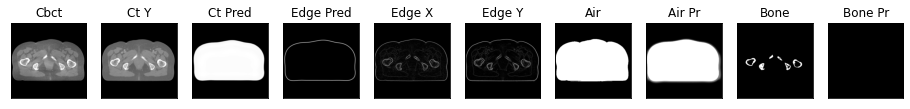

169it [01:03,  2.82it/s]

ssim score = 0.788642406463623
psnr score = 20.210460662841797
snr score = 10.910165786743164
mae error = 0.04683462157845497
air dice score = 0.9865349511435724
bone dice score = 3.688675765264158e-11
contour dice score = 0.14363010227680206


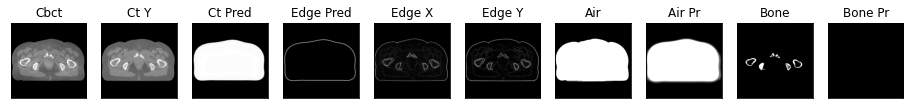

170it [01:03,  2.85it/s]

ssim score = 0.785558819770813
psnr score = 20.220428466796875
snr score = 10.951454162597656
mae error = 0.046724963933229446
air dice score = 0.9868350560385256
bone dice score = 3.631082062322764e-11
contour dice score = 0.16015625


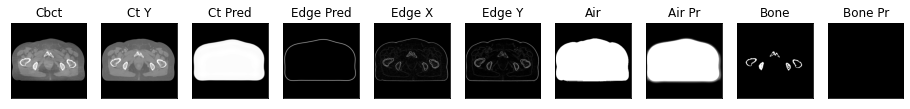

171it [01:04,  2.43it/s]

ssim score = 0.7814199924468994
psnr score = 20.1485652923584
snr score = 10.927961349487305
mae error = 0.04704785346984863
air dice score = 0.987384584647448
bone dice score = 3.547357218746103e-11
contour dice score = 0.18121442198753357


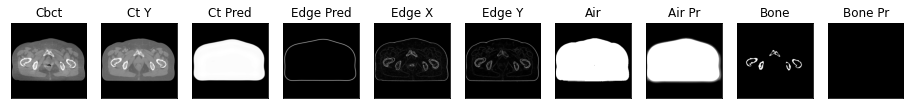

172it [01:04,  2.54it/s]

ssim score = 0.7795084118843079
psnr score = 20.10816764831543
snr score = 10.930305480957031
mae error = 0.04718615859746933
air dice score = 0.9870389117819094
bone dice score = 3.3090668430407324e-11
contour dice score = 0.13960252702236176


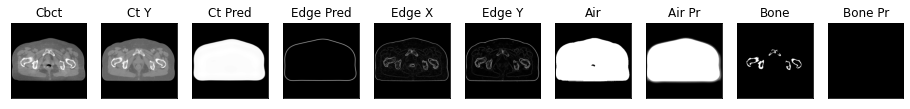

173it [01:04,  2.63it/s]

ssim score = 0.7715775370597839
psnr score = 19.932598114013672
snr score = 10.842437744140625
mae error = 0.04834871366620064
air dice score = 0.9861397985783777
bone dice score = 2.8352707682779906e-11
contour dice score = 0.14238566160202026


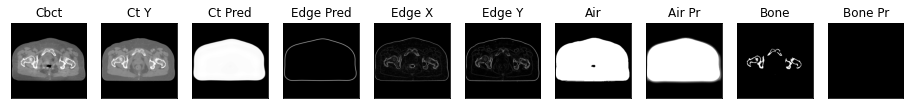

174it [01:05,  2.70it/s]

ssim score = 0.7731013298034668
psnr score = 19.889198303222656
snr score = 10.912312507629395
mae error = 0.048631053417921066
air dice score = 0.9888476892696382
bone dice score = 2.341372043962974e-11
contour dice score = 0.1692236214876175


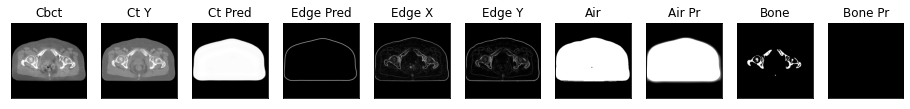

175it [01:05,  2.75it/s]

ssim score = 0.776517391204834
psnr score = 20.250463485717773
snr score = 11.145024299621582
mae error = 0.04620818793773651
air dice score = 0.985334581454071
bone dice score = 3.394433129552124e-11
contour dice score = 0.1276199370622635


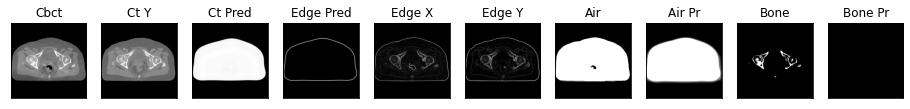

176it [01:05,  2.79it/s]

ssim score = 0.7787597179412842
psnr score = 20.281177520751953
snr score = 11.066316604614258
mae error = 0.045896537601947784
air dice score = 0.9853855413155949
bone dice score = 3.8654812522665065e-11
contour dice score = 0.13659915328025818


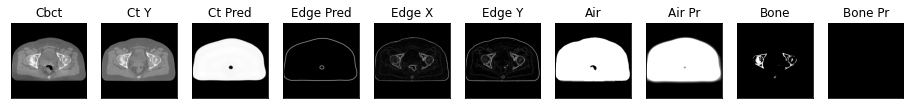

177it [01:06,  2.80it/s]

ssim score = 0.7845971584320068
psnr score = 20.278156280517578
snr score = 11.036168098449707
mae error = 0.04687769338488579
air dice score = 0.985267138946131
bone dice score = 3.427004797689273e-11
contour dice score = 0.1864328533411026


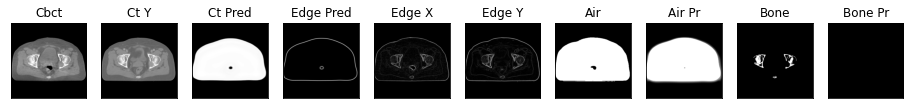

178it [01:06,  2.82it/s]

ssim score = 0.7952679991722107
psnr score = 20.494335174560547
snr score = 11.244342803955078
mae error = 0.0470585823059082
air dice score = 0.9870840829698999
bone dice score = 3.3222591361022506e-11
contour dice score = 0.26923078298568726


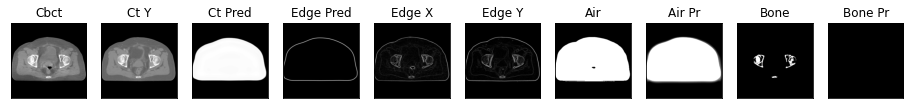

179it [01:06,  2.84it/s]

ssim score = 0.7957773208618164
psnr score = 20.273807525634766
snr score = 11.05804443359375
mae error = 0.048466213047504425
air dice score = 0.9881714822155084
bone dice score = 3.164556961925172e-11
contour dice score = 0.2717803120613098


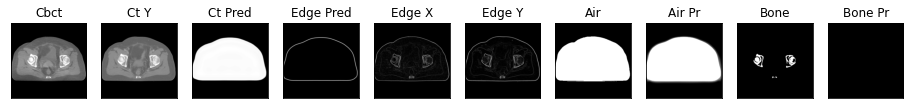

180it [01:07,  2.85it/s]

ssim score = 0.7930117845535278
psnr score = 19.900203704833984
snr score = 10.735930442810059
mae error = 0.050143081694841385
air dice score = 0.988660128237876
bone dice score = 3.162555344618515e-11
contour dice score = 0.27659574151039124


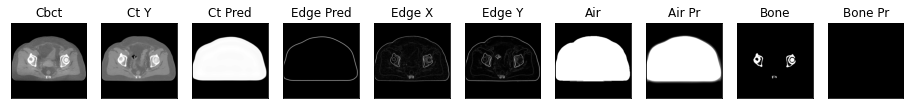

181it [01:07,  2.43it/s]

ssim score = 0.7811865210533142
psnr score = 19.645954132080078
snr score = 10.51923942565918
mae error = 0.051090534776449203
air dice score = 0.9888547560566848
bone dice score = 3.448275861950059e-11
contour dice score = 0.2497570514678955


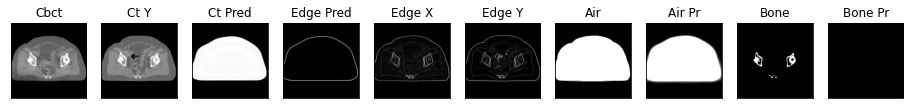

182it [01:08,  2.55it/s]

ssim score = 0.7736484408378601
psnr score = 19.556657791137695
snr score = 10.357507705688477
mae error = 0.05224478989839554
air dice score = 0.9888674685709706
bone dice score = 4.456327985541162e-11
contour dice score = 0.22123894095420837


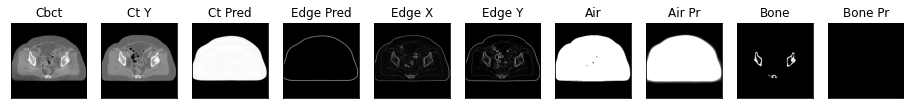

183it [01:08,  2.63it/s]

ssim score = 0.7689106464385986
psnr score = 19.40331268310547
snr score = 10.186168670654297
mae error = 0.05337736755609512
air dice score = 0.9876548209645387
bone dice score = 4.468275245555484e-11
contour dice score = 0.24601593613624573


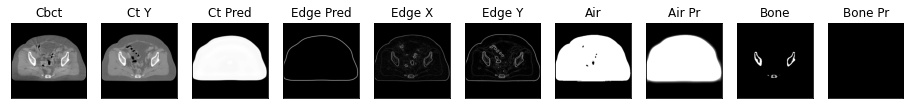

184it [01:08,  2.69it/s]

ssim score = 0.7801705002784729
psnr score = 19.80923843383789
snr score = 10.657007217407227
mae error = 0.05166773125529289
air dice score = 0.9879569490937784
bone dice score = 4.2863266179045725e-11
contour dice score = 0.1799204796552658


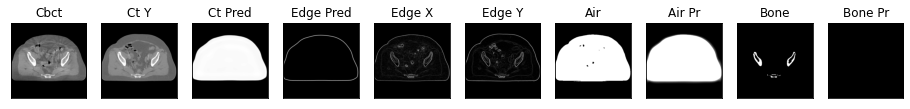

185it [01:09,  2.74it/s]

ssim score = 0.7727276086807251
psnr score = 19.469547271728516
snr score = 10.372411727905273
mae error = 0.05413036793470383
air dice score = 0.9881447491090457
bone dice score = 3.6656891494257445e-11
contour dice score = 0.1825476437807083


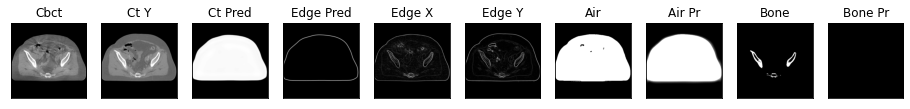

186it [01:09,  2.77it/s]

ssim score = 0.7599208354949951
psnr score = 18.972755432128906
snr score = 9.940048217773438
mae error = 0.05729487165808678
air dice score = 0.9875233117070819
bone dice score = 3.059975520102204e-11
contour dice score = 0.23442137241363525


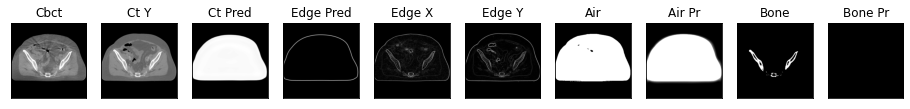

187it [01:09,  2.80it/s]

ssim score = 0.7599258422851562
psnr score = 19.099000930786133
snr score = 10.139155387878418
mae error = 0.05709380656480789
air dice score = 0.9864891223781314
bone dice score = 2.839295854547436e-11
contour dice score = 0.1792079210281372


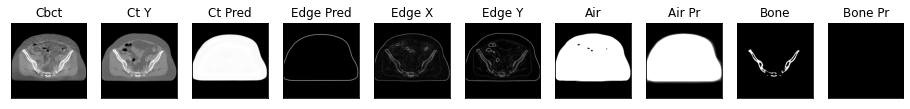

188it [01:10,  2.83it/s]

ssim score = 0.7522068023681641
psnr score = 19.096628189086914
snr score = 10.132490158081055
mae error = 0.05767461284995079
air dice score = 0.9864487097544844
bone dice score = 2.908667830049195e-11
contour dice score = 0.2328094244003296


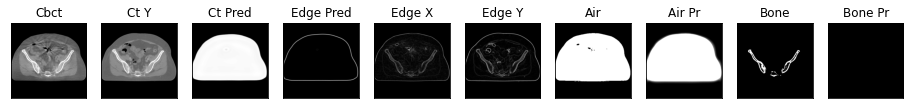

189it [01:10,  2.84it/s]

ssim score = 0.7505168914794922
psnr score = 19.045310974121094
snr score = 10.058998107910156
mae error = 0.0586705207824707
air dice score = 0.9872782334223362
bone dice score = 2.8145229382827323e-11
contour dice score = 0.22189638018608093


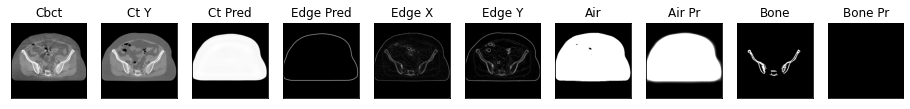

190it [01:10,  2.85it/s]

ssim score = 0.7586258053779602
psnr score = 19.45962142944336
snr score = 10.484943389892578
mae error = 0.057119954377412796
air dice score = 0.9885455294602462
bone dice score = 2.935995302321315e-11
contour dice score = 0.2154294103384018


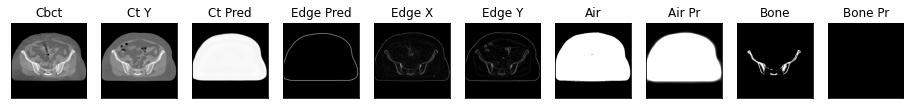

191it [01:11,  2.67it/s]


In [47]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [48]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [49]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [50]:
# score_ssim, score_psnr, score_snr, score_mae, score_air, score_bone, score_cont_test, score_acc_test
# unmasked
eval_epoch(model, discriminator, testloader, device)

191it [00:05, 33.23it/s]


(0.790656852472515,
 19.735958388962672,
 10.740230435476253,
 0.045175558053620196,
 0.9872298499648239,
 2.9564617685948747e-11,
 0.12510830699100467,
 0.5)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)